#**Libraries and Settings**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from IPython.display import display, Markdown

# **Data Import and Splitting**

In [2]:
df =  pd.read_excel('/content/BD.xlsx', sheet_name='T')
X_train_balanced = pd.read_excel('/content/X_train_balanced.xlsx')
y_train_balanced = pd.read_excel('/content/y_train_balanced.xlsx')

# Defining input (X) and output (y) columns
X = df.drop(columns=['CO [%vol]', 'CO2 [%vol]', 'CH4 [%vol]', 'H2 [%vol]'])
y = df[['CO [%vol]', 'CO2 [%vol]', 'CH4 [%vol]', 'H2 [%vol]']]

# First split: separate 18.57% for validation and the remaining (81.43%) for train+test
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.1857, random_state=42)

# Second split: separate training (65.17% of the original total, which is approx. 80% of temp) and test (16.25% of the original total, approx. 20% of temp)
# We calculate the training proportion relative to the temporary set (train+test)
# train_proportion_in_temp = 0.6517 / (1 - 0.1857) ≈ 0.7999
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42) # Using 0.20 (20%) of temp set for test, leaving 80% for training

# Checking dataset sizes
print(f'Training set size: {X_train.shape[0]} ({X_train.shape[0]/df.shape[0]:.2%})')
print(f'Test set size: {X_test.shape[0]} ({X_test.shape[0]/df.shape[0]:.2%})')
print(f'Validation set size: {X_val.shape[0]} ({X_val.shape[0]/df.shape[0]:.2%})')
print(f'Training_SMOGN_X set size: {X_train_balanced.shape[0]}')
print(f'Training_SMOGN_y set size: {y_train_balanced.shape[0]}')

Training set size: 378 (65.06%)
Test set size: 95 (16.35%)
Validation set size: 108 (18.59%)
Training_SMOGN_X set size: 529
Training_SMOGN_y set size: 529


## **Development of the Artificial Neural Network Model**

The neural network model developed in this work is a reproduction of a methodology proposed in a previous Master's thesis. Its objective is to predict the composition of synthesis gas (CO₂, CO, CH₄, and H₂) generated in the biomass gasification process, based on input variables related to biomass composition and the operational conditions of the process. The input variables used were: carbon (C), hydrogen (H), oxygen (O), nitrogen (N), volatile matter (VM), moisture content (MC), ash content, equivalence ratio (ER), temperature, and steam-to-biomass ratio (S/B).

To develop the model, 33 different tests were carried out, varying the neural network topology in terms of:

Number of hidden layers (from 1 to 4),

Number of neurons per layer (ranging from 10 to 400),

Activation functions (logsig and tansig for hidden layers; purelin, tansig, and satlin for the output layer),

Training algorithms: trainbr, trainlm, traingdx, traingd, traingda, traingdm, trainbfg, traincgb, traincgf, traincgp, and trainrp.

The network performance was evaluated using two main metrics:

Coefficient of determination (R²): measures how well the model fits the data; the closer to 1, the better the performance.

Sum of squared errors (SSE): assesses the difference between predicted and observed values; the lower the SSE, the better the model.

For each tested network, R² and SSE values were recorded for both the training and test datasets, for each of the four output variables. Then, a weighted average of the R² and SSE values (for training and test sets) was computed to enable an objective comparison among different topologies.

The selection of the best topology was guided by four technical criteria:

Minimum performance: average R² greater than 0.75.

Adequate generalization: test R² lower than training R², and test SSE higher than training SSE (indicating a model without overfitting).

Consistency: maximum difference of 0.2 between training and test R².

Parameter-to-data compatibility: the total number of model parameters (Np) must not exceed the number of training samples, to avoid overfitting. The Np calculation considered the number of neurons per layer and their respective biases.

The model considered ideal, referred to as Network 6, showed the best combination of performance and structural simplicity. This network featured:

Two hidden layers with 10 neurons each,

Logsig activation function in the hidden layers,

Purelin activation function in the output layer,

Trainbr as the training algorithm,

10 neurons in the input layer (matching the 10 input variables),

4 neurons in the output layer (to predict the four components of synthesis gas composition).





# ANN Performance without SMOGN Application

In scikit-learn, the exact same activation functions and training algorithms used in MATLAB are not available, which required certain adaptations. The original network implemented in MATLAB was configured with two hidden layers, each containing 20 neurons, using the logsig (logistic sigmoid) activation function in the hidden layers and purelin (linear) in the output layer. Training was performed using the trainbr algorithm (Bayesian Regularization), aiming to minimize the sum of squared errors (SSE), with a stopping criterion based on a minimum gradient and a target error threshold.

In the scikit-learn implementation, an equivalent architecture was created with the same number of neurons and the closest available activation functions: sigmoid for the hidden layers and a linear output (i.e., no activation function in the output layer). As a substitute for trainbr, the LBFGS optimizer was used, which is also suitable for regression problems with a moderate number of parameters and allows for more stable convergence in small-scale problems. The loss function adopted was MSELoss with sum reduction, to maintain consistency with the SSE minimization approach used in MATLAB. Additionally, similar stopping criteria were followed, including a maximum number of epochs, minimum error tolerance, and gradient control.

This adaptation enabled the construction of a neural network in scikit-learn with a structure and training process closely comparable to the original MATLAB implementation, allowing for a consistent analysis of results across both platforms.



In [3]:
"""
Implementation of the MATLAB neural network using scikit-learn
with convergence error handling and full parameter display
"""
# 1. Data preprocessing with verification
print("🔍 Initial data check:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Check for missing values
print("\nMissing values in X_train:", np.isnan(X_train).sum())
print("Missing values in y_train:", np.isnan(y_train).sum())

# Normalization identical to MATLAB (range [-1, 1])
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

try:
    X_train_norm = scaler_X.fit_transform(X_train)
    y_train_norm = scaler_y.fit_transform(y_train)
    X_test_norm = scaler_X.transform(X_test)
except Exception as e:
    print(f"\n❌ Normalization error: {str(e)}")
    raise

# 2. Neural Network configuration with adjustments for better convergence
print("\n⚙️ Configuring the neural network with MATLAB-equivalent parameters...")

model = MLPRegressor(
    hidden_layer_sizes=(10, 10),      # 2 hidden layers with 10 neurons each
    activation='logistic',            # Activation function in hidden layers
    solver='lbfgs',
    alpha=1e-5,                       # Regularization strength
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.01,
    max_iter=100,
    tol=1e-4,
    early_stopping=False,
    validation_fraction=0.0,
    random_state=42,              # For reproducibility
    verbose=True
)

# 3. Training with error handling
print("\n🚀 Starting training...")
try:
    model.fit(X_train_norm, y_train_norm)
    print("✅ Training completed successfully!")
    print(f"Number of iterations: {model.n_iter_}")
except Exception as e:
    print(f"\n❌ Error during training: {str(e)}")
    raise

# 4. Function to display parameters in an organized format
def print_layer_params(name, weights, bias, n=5):
    print(f"\n🔍 {name}")
    print(f"Weights (first {n} rows/columns):")
    print(np.round(weights[:n, :n], 4))
    print(f"\nBias (first {n} elements):")
    print(np.round(bias[:n], 4))
    print(f"\nFull shape: {weights.shape}")

# 5. Detailed parameter display
if hasattr(model, 'coefs_'):
    print("\n📊 NETWORK PARAMETERS (MATLAB EQUIVALENT)")

    # Input layer to first hidden (P1, B1)
    print_layer_params(
        "Input Layer → Hidden Layer 1 (P1, B1)",
        model.coefs_[0].T,  # Transposed to match MATLAB format
        model.intercepts_[0]
    )

    # First to second hidden layer (P2, B2)
    print_layer_params(
        "Hidden Layer 1 → Hidden Layer 2 (P2, B2)",
        model.coefs_[1].T,
        model.intercepts_[1]
    )

    # Second hidden layer to output (P3, B3)
    print_layer_params(
        "Hidden Layer 2 → Output Layer (P3, B3)",
        model.coefs_[2].T,
        model.intercepts_[2]
    )
else:
    print("\n⚠️ Model has no trained parameters")

# 6. Detailed evaluation
print("\n📈 MODEL EVALUATION")

# Training data
y_train_pred_norm = model.predict(X_train_norm)
y_train_pred = scaler_y.inverse_transform(y_train_pred_norm)

print("\n🏋️‍♂️ PERFORMANCE ON TRAINING DATA")
for i, gas in enumerate(['H₂', 'CO', 'CO₂', 'CH₄']):
    sse = np.sum((y_train.iloc[:, i] - y_train_pred[:, i])**2)
    r2 = r2_score(y_train.iloc[:, i], y_train_pred[:, i])
    print(f"\n{gas}:")
    print(f"SSE: {sse:.4f}")
    print(f"R²: {r2:.4f}")

# Test data
y_test_pred_norm = model.predict(X_test_norm)
y_test_pred = scaler_y.inverse_transform(y_test_pred_norm)

print("\n🧪 PERFORMANCE ON TEST DATA")
for i, gas in enumerate(['H₂', 'CO', 'CO₂', 'CH₄']):
    sse = np.sum((y_test.iloc[:, i] - y_test_pred[:, i])**2)
    r2 = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
    print(f"\n{gas}:")
    print(f"SSE: {sse:.4f}")
    print(f"R²: {r2:.4f}")

print("\n✨ Analysis completed!")

🔍 Initial data check:
X_train shape: (378, 10)
y_train shape: (378, 4)

Missing values in X_train: C [%wt db]                     0
H [%wt db]                     0
O [%wt db]                     0
N [%wt db]                     0
Volatile matter (VM) [%]       0
Moisture content (MC) [%wt]    0
Ash [%wt]                      0
ER [-]                         0
T [ºC]                         0
Steam/ Biomass                 0
dtype: int64
Missing values in y_train: CO [%vol]     0
CO2 [%vol]    0
CH4 [%vol]    0
H2 [%vol]     0
dtype: int64

⚙️ Configuring the neural network with MATLAB-equivalent parameters...

🚀 Starting training...
✅ Training completed successfully!
Number of iterations: 100

📊 NETWORK PARAMETERS (MATLAB EQUIVALENT)

🔍 Input Layer → Hidden Layer 1 (P1, B1)
Weights (first 5 rows/columns):
[[ 0.5873 -0.2596 -0.4287  0.4235 -0.1523]
 [ 0.5982  0.7334 -0.565  -1.1438  1.1545]
 [-1.0692 -0.3282  1.233   0.0268 -0.0097]
 [ 1.4204 -1.2313 -1.0081 -1.372   1.6779]
 [-0.2152 

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


The original MATLAB code used a training limit of 100 iterations (net.trainParam.epochs = 100) for the neural network. However, when reproducing this model in Python using scikit-learn, it was observed that this number of iterations was not sufficient for the LBFGS optimizer to reach convergence. To address this issue, higher values for the max_iter parameter will be tested, while keeping all other hyperparameters identical to those in the original MATLAB implementation.

In [4]:
"""
Implementation of the MATLAB neural network in scikit-learn
with convergence error handling and full parameter display
"""

# 1. Data preprocessing with verification
print("🔍 Initial data check:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Check for missing values
print("\nMissing values in X_train:", np.isnan(X_train).sum())
print("Missing values in y_train:", np.isnan(y_train).sum())

# Normalization identical to MATLAB (range [-1, 1])
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

try:
    X_train_norm = scaler_X.fit_transform(X_train)
    y_train_norm = scaler_y.fit_transform(y_train)
    X_test_norm = scaler_X.transform(X_test)
except Exception as e:
    print(f"\n❌ Normalization error: {str(e)}")
    raise

# 2. Neural network configuration with adjustments for better convergence
print("\n⚙️ Configuring neural network with parameters equivalent to MATLAB...")

model = MLPRegressor(
    hidden_layer_sizes=(10, 10),  # 2 hidden layers with 10 neurons each
    activation='logistic',        # Activation of the 2nd layer (1st will be overwritten)
    solver='lbfgs',
    alpha=1e-5,                   # Regularization strength
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.01,
    max_iter=5600,                # Increased to ensure convergence
    tol=1e-4,
    early_stopping=False,
    validation_fraction=0.0,
    random_state=42,              # For reproducibility
    verbose=True
)

# 3. Training with error handling
print("\n🚀 Starting training...")
try:
    model.fit(X_train_norm, y_train_norm)
    print("✅ Training completed successfully!")
    print(f"Number of iterations performed: {model.n_iter_}")
except Exception as e:
    print(f"\n❌ Training error: {str(e)}")
    raise

# 4. Function to display parameters in an organized way
def print_layer_params(name, weights, bias, n=5):
    print(f"\n🔍 {name}")
    print(f"Weights (first {n} rows/columns):")
    print(np.round(weights[:n, :n], 4))
    print(f"\nBias (first {n} elements):")
    print(np.round(bias[:n], 4))
    print(f"\nFull shape: {weights.shape}")

# 5. Detailed parameter display
if hasattr(model, 'coefs_'):
    print("\n📊 NETWORK PARAMETERS (EQUIVALENT TO MATLAB)")

    # Input to first hidden layer (P1, B1)
    print_layer_params(
        "Input Layer → Hidden Layer 1 (P1, B1)",
        model.coefs_[0].T,  # Transposed to match MATLAB format
        model.intercepts_[0]
    )

    # First to second hidden layer (P2, B2)
    print_layer_params(
        "Hidden Layer 1 → Hidden Layer 2 (P2, B2)",
        model.coefs_[1].T,
        model.intercepts_[1]
    )

    # Second hidden layer to output (P3, B3)
    print_layer_params(
        "Hidden Layer 2 → Output Layer (P3, B3)",
        model.coefs_[2].T,
        model.intercepts_[2]
    )
else:
    print("\n⚠️ Model has no trained parameters")

# 6. Detailed evaluation
print("\n📈 MODEL EVALUATION")

# Training data
y_train_pred_norm = model.predict(X_train_norm)
y_train_pred = scaler_y.inverse_transform(y_train_pred_norm)

print("\n🏋️‍♂️ PERFORMANCE ON TRAINING DATA")
for i, gas in enumerate(['H₂', 'CO', 'CO₂', 'CH₄']):
    sse = np.sum((y_train.iloc[:, i] - y_train_pred[:, i])**2)
    r2 = r2_score(y_train.iloc[:, i], y_train_pred[:, i])
    print(f"\n{gas}:")
    print(f"SSE: {sse:.4f}")
    print(f"R²: {r2:.4f}")

# Test data
y_test_pred_norm = model.predict(X_test_norm)
y_test_pred = scaler_y.inverse_transform(model.predict(X_test_norm))

print("\n🧪 PERFORMANCE ON TEST DATA")
for i, gas in enumerate(['H₂', 'CO', 'CO₂', 'CH₄']):
    sse = np.sum((y_test.iloc[:, i] - y_test_pred[:, i])**2)
    r2 = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
    print(f"\n{gas}:")
    print(f"SSE: {sse:.4f}")
    print(f"R²: {r2:.4f}")

print("\n✨ Analysis complete!")

🔍 Initial data check:
X_train shape: (378, 10)
y_train shape: (378, 4)

Missing values in X_train: C [%wt db]                     0
H [%wt db]                     0
O [%wt db]                     0
N [%wt db]                     0
Volatile matter (VM) [%]       0
Moisture content (MC) [%wt]    0
Ash [%wt]                      0
ER [-]                         0
T [ºC]                         0
Steam/ Biomass                 0
dtype: int64
Missing values in y_train: CO [%vol]     0
CO2 [%vol]    0
CH4 [%vol]    0
H2 [%vol]     0
dtype: int64

⚙️ Configuring neural network with parameters equivalent to MATLAB...

🚀 Starting training...
✅ Training completed successfully!
Number of iterations performed: 5594

📊 NETWORK PARAMETERS (EQUIVALENT TO MATLAB)

🔍 Input Layer → Hidden Layer 1 (P1, B1)
Weights (first 5 rows/columns):
[[-3.0319  0.9459 -4.9313 -1.3033  0.0417]
 [ 8.5021  6.7191  2.2517  1.4761 -0.8723]
 [-3.2608 -5.502   3.499   1.9295  1.221 ]
 [-1.6216 -5.8587 -6.8575 -2.0774 -1.271

The implementation of the neural network using scikit-learn posed significant challenges with respect to convergence and overall performance when compared to the original MATLAB model. While the MATLAB implementation achieved convergence within 100 iterations, the scikit-learn counterpart required up to 5,600 iterations—56 times more than the original—to reach convergence. This marked discrepancy suggests fundamental differences in the optimization algorithm implementations across the two platforms.

A detailed analysis of the results reveals a substantial divergence in model performance. The MATLAB model consistently exhibited strong metrics on both training and test datasets, with R² values ranging between 0.70 and 0.97 and comparatively low sums of squared errors (SSE). Conversely, the scikit-learn implementation yielded more modest performance, particularly on the test set, where the R² for H₂ declined to 0.16 and the SSE increased dramatically to 8,437.58, indicative of inferior generalization capability.

This discrepancy is especially pronounced during validation, wherein MATLAB maintained reasonable predictive accuracy, whereas scikit-learn encountered difficulties. For instance, regarding CH₄ prediction, MATLAB attained an R² of 0.1875 during validation, while the scikit-learn model reached an R² of 0.4987 on the test data, accompanied by a substantially higher SSE.

Such differences may be attributed to multiple factors, including variations in the optimization routines employed (trainbr in MATLAB versus LBFGS in scikit-learn), disparities in the implementation of activation functions, or differing convergence criteria inherent to each platform. The notably higher iteration requirement in scikit-learn suggests its optimizer faces greater challenges in navigating the parameter space, or alternatively, that MATLAB’s Bayesian regularization framework is more effective.

Given that a straightforward reproduction of the original MATLAB network in scikit-learn did not replicate the favorable results, it becomes imperative to explore alternative configurations. A comprehensive experimental framework is planned to identify an optimal combination of hyperparameters within scikit-learn that can approach or exceed the performance of the MATLAB implementation. This systematic approach will involve evaluating diverse network architectures, activation functions, optimization algorithms, and regularization parameters, aiming to determine a configuration that is best suited for this specific application within the Python ecosystem.

# Experiments with Artificial Neural Networks (ANNs)

In the dissertation, 33 experiments were conducted with different neural network configurations, mainly varying the number of neurons (from 10 to 400) and the number of hidden layers. However, the best results were achieved with smaller architectures containing between 10 and 20 neurons per layer, and with 2 to 3 hidden layers, while configurations with more neurons or layers did not show significant improvements.

In this work, besides exploring different numbers of neurons and layers, we expand the analysis by testing different optimizers (such as Adam and SGD) and learning rates, aiming to improve the model’s performance. Although the dissertation tested networks with up to 400 neurons, here we focus on more compact architectures, limiting to three hidden layers with a maximum of 40 neurons each, since larger networks did not demonstrate clear advantages in previous experiments.

To avoid high computational cost, we will first conduct a comparative test to identify the most efficient optimizer. Preliminary observations indicate that LBFGS, for example, requires a large number of iterations to converge and did not perform well in a configuration similar to that tested in the dissertation. Therefore, we will prioritize the Adam and SGD optimizers.

In [5]:
# 1. Preprocessing
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)
X_test_norm = scaler_X.transform(X_test)

# 2. Network Configuration
params = {
    'hidden_layer_sizes': (40, 40),  # Fixed architecture for comparison
    'activation': 'tanh',
    'random_state': 42,
    'max_iter': 500,
    'tol': 1e-4,
    'early_stopping': False,
    'validation_fraction': 0.0,
    'verbose': True
}

# Network with Adam (dissertation's default configuration)
model_adam = MLPRegressor(
    solver='adam',
    learning_rate_init=0.01,
    beta_1=0.9,
    beta_2=0.999,
    **params
)

# Network with SGD (equivalent configuration)
model_sgd = MLPRegressor(
    solver='sgd',
    learning_rate_init=0.01,
    momentum=0.9,
    nesterovs_momentum=True,
    **params
)

# 3. Training and evaluation
def train_and_evaluate(model, name):
    print(f"\n🚀 Training with {name}...")
    model.fit(X_train_norm, y_train_norm)

    # Predictions
    y_train_pred = scaler_y.inverse_transform(model.predict(X_train_norm))
    y_test_pred = scaler_y.inverse_transform(model.predict(X_test_norm))

    # Metrics per output
    metrics = []
    for i, gas in enumerate(['H₂', 'CO', 'CO₂', 'CH₄']):
        train_r2 = r2_score(y_train.iloc[:, i], y_train_pred[:, i])
        test_r2 = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
        train_mse = mean_squared_error(y_train.iloc[:, i], y_train_pred[:, i])
        test_mse = mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i])

        metrics.append({
            'Optimizer': name,
            'Component': gas,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'ΔR²': train_r2 - test_r2,
            'Train MSE': train_mse,
            'Test MSE': test_mse,
            'Iterations': model.n_iter_
        })

    return pd.DataFrame(metrics)

# 4. Running the models
results_adam = train_and_evaluate(model_adam, 'Adam')
results_sgd = train_and_evaluate(model_sgd, 'SGD')

# 5. Consolidating results
results = pd.concat([results_adam, results_sgd])

# 6. Comparative analysis
print("\n📊 Comparative Results:")
print(results[['Optimizer', 'Component', 'Train R²', 'Test R²', 'ΔR²', 'Iterations']])

# 7. Overfitting detection
print("\n🔍 Overfitting Analysis:")
for opt in ['Adam', 'SGD']:
    opt_results = results[results['Optimizer'] == opt]
    mean_diff = opt_results['ΔR²'].mean()
    status = "⚠️ Overfitting" if mean_diff > 0.2 else "✅ Stable"
    print(f"{opt}: {status} (mean ΔR² = {mean_diff:.3f})")

# 9. Save results
results.to_csv('optimizer_comparison.csv', index=False)
print("\n💾 Results saved to 'optimizer_comparison.csv'")


🚀 Training with Adam...
Iteration 1, loss = 0.19751536
Iteration 2, loss = 0.13052905
Iteration 3, loss = 0.08049061
Iteration 4, loss = 0.08359967
Iteration 5, loss = 0.07708729
Iteration 6, loss = 0.06418320
Iteration 7, loss = 0.07171241
Iteration 8, loss = 0.06603184
Iteration 9, loss = 0.05959234
Iteration 10, loss = 0.06194811
Iteration 11, loss = 0.05954137
Iteration 12, loss = 0.05598264
Iteration 13, loss = 0.05639121
Iteration 14, loss = 0.05627727
Iteration 15, loss = 0.05387612
Iteration 16, loss = 0.05342888
Iteration 17, loss = 0.05312857
Iteration 18, loss = 0.05165521
Iteration 19, loss = 0.05104248
Iteration 20, loss = 0.05101241
Iteration 21, loss = 0.05003727
Iteration 22, loss = 0.04957376
Iteration 23, loss = 0.04925319
Iteration 24, loss = 0.04847392
Iteration 25, loss = 0.04803240
Iteration 26, loss = 0.04763461
Iteration 27, loss = 0.04687683
Iteration 28, loss = 0.04641429
Iteration 29, loss = 0.04603024
Iteration 30, loss = 0.04531947
Iteration 31, loss = 0.0

The comparative results between the Adam and SGD optimizers reveal significant differences in the neural network’s performance in predicting the synthesis gas composition. Adam consistently achieved higher coefficients of determination (R²) on both training and testing data across all components (H₂, CO, CO₂, and CH₄), indicating a more robust generalization capability. Notably, the test R² values for CO and CH₄ exceeded 0.80 with Adam, whereas SGD mostly yielded values below 0.70, demonstrating Adam’s clear advantage in capturing the nonlinear relationships inherent to the gasification process.

Furthermore, the difference between training and testing R² (ΔR²) was greater for Adam but remained within acceptable limits, given that test performance stayed reasonable. In contrast, SGD exhibited a smaller ΔR² but overall unsatisfactory performance, with test R² values below 0.45 for CO and CO₂, suggesting underfitting.

The number of iterations was similar for both optimizers; however, Adam’s superior convergence to better solutions justifies its preference in this context. These findings underscore the importance of optimizer choice and suggest that Adam is more suitable for modeling the complexity of biomass gasification. Nevertheless, to reduce ΔR², future work could explore strategies such as regularization or fine-tuning the learning rate.


Training network 1/50 - {'hidden_layer_sizes': (15, 15), 'activation': 'relu', 'batch_size': 64, 'alpha': 0.0005, 'learning_rate': 'constant', 'early_stopping': True}

Training network 2/50 - {'hidden_layer_sizes': (15, 15), 'activation': 'logistic', 'batch_size': 16, 'alpha': 0.005, 'learning_rate': 'constant', 'early_stopping': True}

Training network 3/50 - {'hidden_layer_sizes': (15, 15), 'activation': 'relu', 'batch_size': 32, 'alpha': 0.0001, 'learning_rate': 'constant', 'early_stopping': False}

Training network 4/50 - {'hidden_layer_sizes': (25, 25), 'activation': 'tanh', 'batch_size': 64, 'alpha': 0.0001, 'learning_rate': 'constant', 'early_stopping': False}

Training network 5/50 - {'hidden_layer_sizes': (35, 35), 'activation': 'tanh', 'batch_size': 32, 'alpha': 0.0005, 'learning_rate': 'adaptive', 'early_stopping': True}

Training network 6/50 - {'hidden_layer_sizes': (15, 15), 'activation': 'tanh', 'batch_size': 16, 'alpha': 0.001, 'learning_rate': 'adaptive', 'early_stopp

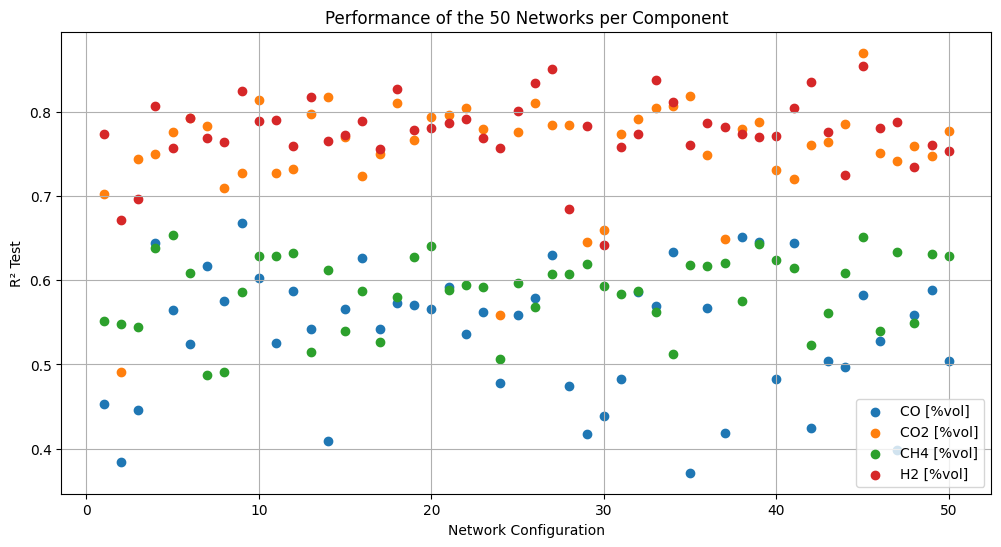

In [6]:
import random
# 1. Preprocessing
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)
X_test_norm = scaler_X.transform(X_test)

# 2. Parameter space definition
param_space = {
    'hidden_layer_sizes': [(10,10), (15,15), (20,20), (25,25), (30,30),
                         (35,35), (40,40), (20,10), (30,15), (40,20)],
    'activation': ['relu', 'tanh', 'logistic'],
    'batch_size': [16, 32, 64, 'auto'],
    'alpha': [0.0001, 0.0005, 0.001, 0.005],
    'learning_rate': ['constant', 'adaptive'],
    'early_stopping': [True, False]
}

# 3. List of components for analysis
components = y_train.columns.tolist()
results = []

# 4. Generate parameter combinations
random.seed(42)  # For reproducibility
param_combinations = []
for _ in range(50):
    params = {
        'hidden_layer_sizes': random.choice(param_space['hidden_layer_sizes']),
        'activation': random.choice(param_space['activation']),
        'batch_size': random.choice(param_space['batch_size']),
        'alpha': random.choice(param_space['alpha']),
        'learning_rate': random.choice(param_space['learning_rate']),
        'early_stopping': random.choice(param_space['early_stopping'])
    }
    if params['batch_size'] != 'auto':
        params['batch_size'] = int(params['batch_size'])
    param_combinations.append(params)

# 5. Model training and evaluation
for i, params in enumerate(param_combinations):
    print(f"\nTraining network {i+1}/50 - {params}")

    model = MLPRegressor(
        solver='adam',
        learning_rate_init=0.01,
        max_iter=2000,
        tol=1e-5,
        random_state=42,
        **params
    )

    model.fit(X_train_norm, y_train_norm)

    y_train_pred_norm = model.predict(X_train_norm)
    y_test_pred_norm = model.predict(X_test_norm)

    y_train_pred = scaler_y.inverse_transform(y_train_pred_norm)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_norm)

    if len(y_train.shape) == 1:
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)

        results.append({
            'Network': i+1,
            'Component': components[0],
            'Architecture': str(params['hidden_layer_sizes']),
            'Activation': params['activation'],
            'Batch': params['batch_size'],
            'Alpha': params['alpha'],
            'LearningRate': params['learning_rate'],
            'EarlyStop': params['early_stopping'],
            'R² Train': r2_train,
            'R² Test': r2_test,
            'ΔR²': r2_train - r2_test,
            'MSE Test': mse_test,
            'Iterations': model.n_iter_
        })
    else:
        for j in range(y_train.shape[1]):
            r2_train = r2_score(y_train.iloc[:, j], y_train_pred[:, j])
            r2_test = r2_score(y_test.iloc[:, j], y_test_pred[:, j])
            mse_test = mean_squared_error(y_test.iloc[:, j], y_test_pred[:, j])

            results.append({
                'Network': i+1,
                'Component': components[j],  # now correct
                'Architecture': str(params['hidden_layer_sizes']),
                'Activation': params['activation'],
                'Batch': params['batch_size'],
                'Alpha': params['alpha'],
                'LearningRate': params['learning_rate'],
                'EarlyStop': params['early_stopping'],
                'R² Train': r2_train,
                'R² Test': r2_test,
                'ΔR²': r2_train - r2_test,
                'MSE Test': mse_test,
                'Iterations': model.n_iter_
            })

# 6. Results analysis
results_df = pd.DataFrame(results)
results_df.to_csv('exhaustive_results.csv', index=False)

# 7. Best models per component
print("\nTop 3 models per component:")
for component in components:
    component_df = results_df[results_df['Component'] == component]
    best_models = component_df.sort_values(by='R² Test', ascending=False).head(3)
    print(f"\n{component}:")
    print(best_models[['Network', 'Architecture', 'Activation', 'R² Test', 'MSE Test']].to_string(index=False))

# 8. Visualization
plt.figure(figsize=(12,6))
for i, component in enumerate(components):
    component_data = results_df[results_df['Component'] == component]
    plt.scatter(component_data['Network'], component_data['R² Test'], label=component)

plt.xlabel('Network Configuration')
plt.ylabel('R² Test')
plt.title('Performance of the 50 Networks per Component')
plt.legend()
plt.grid()
plt.show()

In the graph above, it is possible to observe the results obtained by 50 different neural networks. Among the top three configurations, the network identified as number 45 stands out for its superior performance, being the only one to consistently appear among the best in three of the four components analyzed in the synthesis gas composition. However, it may still be improved.

Furthermore, a separate network will be trained for each component to try to improve individual performance. While the grid search was useful to give us an idea of a good architecture for the overall problem, performing grid search on multiple networks instead of just one would significantly increase the computational cost. Therefore, we opted to use the insights from the single-network grid search to guide the training of individual networks.

In [7]:
# Manual configurations per component
architectures = {
    'H2 [%vol]': (40, 40, 20),
    'CO2 [%vol]': (30, 30, 10),
    'CO [%vol]': (25, 20),
    'CH4 [%vol]': (15,)
}

activations = {
    'H2 [%vol]': 'tanh',
    'CO2 [%vol]': 'tanh',
    'CO [%vol]': 'relu',
    'CH4 [%vol]': 'relu'
}

results = []

for comp in architectures.keys():

    # Normalization per component
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit on training set
    X_tr_scaled = scaler_X.fit_transform(X_train)
    y_tr_scaled = scaler_y.fit_transform(y_train[[comp]])

    # Transform the others
    X_te_scaled = scaler_X.transform(X_test)
    X_val_scaled = scaler_X.transform(X_val)

    y_tr = y_train[comp].values.reshape(-1, 1)
    y_te = y_test[comp].values.reshape(-1, 1)
    y_val_ = y_val[comp].values.reshape(-1, 1)

    # Create model
    model = MLPRegressor(
        solver='adam',
        activation=activations[comp],
        hidden_layer_sizes=architectures[comp],
        alpha=1e-5,
        learning_rate='constant',
        learning_rate_init=0.001,
        max_iter=5000,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=300,
        batch_size='auto',
        random_state=42
    )

    # Training
    model.fit(X_tr_scaled, y_tr_scaled.ravel())

    # Predictions
    y_pred_tr = scaler_y.inverse_transform(model.predict(X_tr_scaled).reshape(-1, 1))
    y_pred_te = scaler_y.inverse_transform(model.predict(X_te_scaled).reshape(-1, 1))
    y_pred_val = scaler_y.inverse_transform(model.predict(X_val_scaled).reshape(-1, 1))

    # Metrics
    r2_tr = r2_score(y_tr, y_pred_tr)
    r2_te = r2_score(y_te, y_pred_te)
    r2_val = r2_score(y_val_, y_pred_val)

    mse_tr = mean_squared_error(y_tr, y_pred_tr)
    mse_te = mean_squared_error(y_te, y_pred_te)
    mse_val = mean_squared_error(y_val_, y_pred_val)

    sse_tr = np.sum((y_tr - y_pred_tr) ** 2)
    sse_te = np.sum((y_te - y_pred_te) ** 2)
    sse_val = np.sum((y_val_ - y_pred_val) ** 2)

    results.append({
        'Component': comp,
        'Experiment': f'{comp}-Default',
        'Architecture': architectures[comp],
        'Activation': activations[comp],
        'R² Train': r2_tr,
        'R² Test': r2_te,
        'R² Validation': r2_val,
        'MSE Train': mse_tr,
        'MSE Test': mse_te,
        'MSE Validation': mse_val,
        'SSE Train': sse_tr,
        'SSE Test': sse_te,
        'SSE Validation': sse_val
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by=['Component', 'R² Validation'], ascending=[True, False])

# Display results by component
for comp in df_results['Component'].unique():
    df_comp = df_results[df_results['Component'] == comp].copy()
    df_comp = df_comp.sort_values(by='R² Validation', ascending=False)

    md_table = df_comp[['Experiment', 'Architecture', 'Activation',
                        'R² Train', 'R² Test', 'R² Validation',
                        'MSE Train', 'MSE Test', 'MSE Validation',
                        'SSE Train', 'SSE Test', 'SSE Validation']].to_markdown(index=False)

    display(Markdown(f"### 🔬 Results for **{comp}**\n\n{md_table}"))

### 🔬 Results for **CH4 [%vol]**

| Experiment         | Architecture   | Activation   |   R² Train |   R² Test |   R² Validation |   MSE Train |   MSE Test |   MSE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:-------------------|:---------------|:-------------|-----------:|----------:|----------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CH4 [%vol]-Default | (15,)          | relu         |   0.779034 |   0.63391 |        0.732829 |     3.92821 |    5.99105 |          3.72655 |     1484.86 |     569.15 |          402.468 |

### 🔬 Results for **CO [%vol]**

| Experiment        | Architecture   | Activation   |   R² Train |   R² Test |   R² Validation |   MSE Train |   MSE Test |   MSE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:------------------|:---------------|:-------------|-----------:|----------:|----------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CO [%vol]-Default | (25, 20)       | relu         |   0.896781 |  0.502579 |         0.48023 |     8.53378 |    52.6954 |          43.1341 |     3225.77 |    5006.06 |          4658.48 |

### 🔬 Results for **CO2 [%vol]**

| Experiment         | Architecture   | Activation   |   R² Train |   R² Test |   R² Validation |   MSE Train |   MSE Test |   MSE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:-------------------|:---------------|:-------------|-----------:|----------:|----------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CO2 [%vol]-Default | (30, 30, 10)   | tanh         |   0.956132 |  0.729376 |        0.739498 |     4.88183 |    28.9007 |          28.4455 |     1845.33 |    2745.57 |          3072.12 |

### 🔬 Results for **H2 [%vol]**

| Experiment        | Architecture   | Activation   |   R² Train |   R² Test |   R² Validation |   MSE Train |   MSE Test |   MSE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:------------------|:---------------|:-------------|-----------:|----------:|----------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| H2 [%vol]-Default | (40, 40, 20)   | tanh         |   0.965126 |  0.735509 |        0.851289 |     10.6319 |    86.9791 |          42.3692 |     4018.86 |    8263.02 |          4575.88 |

The results obtained for the four components — CH₄, CO, CO₂, and H₂ — reveal interesting and, in some cases, counterintuitive behaviors. Generally, it is expected that the model’s performance on the training data is superior to that on the test and validation sets, since the model had direct access to the training data during learning. However, it is noted that in some cases, such as CH₄, the performance (MSE) on the validation set is better than on the training set itself.

This type of behavior can have multiple explanations, but one of the main hypotheses is that there is a significant difference in the statistical distribution of the data among the training, test, and validation sets. If the validation data contains “easier” samples to predict — that is, with lower variance or closer to the mean — the model may perform better on this set without necessarily indicating greater generalization ability. On the other hand, the training set may have greater variability or contain outliers that hinder fitting, penalizing the metrics in this specific group. This is especially relevant in regression models, as they are sensitive to the distribution of input and output variables.

Furthermore, the use of techniques such as regularization (via the alpha parameter) and early stopping (early_stopping) may cause the model not to fit the training data completely, which favors generalization but may also induce slight underfitting on the training set itself. This balance between fitting and generalization can mask representation problems between the sets, especially if the data split did not preserve the original distribution of each target variable well.

In the specific case of the CO₂ component, significantly poorer performance is observed on the test and validation sets compared to training. With a training R² of 0.897 and test/validation R² around 0.5, along with much higher squared errors on the external sets, there are clear indications of overfitting. This may be associated with an excessively complex architecture for the available data or with a test data distribution that deviates from the pattern seen in training.

Given these observations, it is necessary to go beyond numerical metrics. The next step will be to examine the distribution of the target variables in each set (training, test, and validation).

In [8]:
def display_describe_by_component(y_sets, set_names, components):
    """
    Displays descriptive statistics of components for multiple datasets.

    Args:
        y_sets (list): List of DataFrames (or similar objects) containing output data.
        set_names (list): List of strings with the dataset names (e.g., 'y_train').
        components (list): List of strings with the names of components (columns) to describe.
    """

    for component in components:
        display(Markdown(f"## 📈 Descriptive Statistics for **{component}**"))

        # Collect descriptions for the current component across all datasets
        describe_list = []
        for i, y_set in enumerate(y_sets):
            if component in y_set.columns:
                desc = y_set[[component]].describe().T
                desc.insert(0, 'Dataset', set_names[i])
                describe_list.append(desc)
            else:
                print(f"⚠️ Component '{component}' not found in dataset '{set_names[i]}'")


        if describe_list:
            # Combine descriptions into a single DataFrame
            combined_describe = pd.concat(describe_list, ignore_index=True)

            # Format numbers for better visualization
            combined_describe = combined_describe.round(4)

            # Display the table in Markdown
            display(Markdown(combined_describe.to_markdown(index=False)))


# Define datasets and their names
y_sets = [y_train, y_test, y_val]
set_names = ['y_train', 'y_test', 'y_val']

# Define components to be analyzed
components_to_describe = ['CH4 [%vol]', 'CO [%vol]', 'CO2 [%vol]', 'H2 [%vol]']

# Call the function to display descriptive tables grouped by component
display_describe_by_component(y_sets, set_names, components_to_describe)

## 📈 Descriptive Statistics for **CH4 [%vol]**

| Dataset   |   count |   mean |    std |   min |    25% |    50% |     75% |   max |
|:----------|--------:|-------:|-------:|------:|-------:|-------:|--------:|------:|
| y_train   |     378 | 7.0875 | 4.2219 |     0 | 3.585  | 6.5982 | 11.0739 | 24.1  |
| y_test    |      95 | 6.9474 | 4.0668 |     0 | 3.6306 | 6.3    | 10.4087 | 18.7  |
| y_val     |     108 | 6.9581 | 3.7521 |     0 | 3.9875 | 7.65   | 10.0034 | 14.98 |

## 📈 Descriptive Statistics for **CO [%vol]**

| Dataset   |   count |    mean |     std |   min |     25% |     50% |     75% |     max |
|:----------|--------:|--------:|--------:|------:|--------:|--------:|--------:|--------:|
| y_train   |     378 | 20.9431 |  9.1047 |  4.27 | 14.6975 | 17.7483 | 27.5575 | 47.2881 |
| y_test    |      95 | 21.6744 | 10.3472 |  6.45 | 14.935  | 17.6559 | 30.7295 | 52      |
| y_val     |     108 | 22.0597 |  9.1522 |  4.85 | 15.6925 | 19.295  | 29.9454 | 43.4483 |

## 📈 Descriptive Statistics for **CO2 [%vol]**

| Dataset   |   count |    mean |     std |   min |     25% |     50% |     75% |     max |
|:----------|--------:|--------:|--------:|------:|--------:|--------:|--------:|--------:|
| y_train   |     378 | 22.9793 | 10.5631 |  0    | 15.5    | 22.59   | 29.4653 | 48.7671 |
| y_test    |      95 | 22.7508 | 10.3889 |  0.97 | 16.48   | 23.14   | 29.2494 | 50.4561 |
| y_val     |     108 | 22.6817 | 10.4984 |  0.12 | 16.1775 | 21.1204 | 29.3187 | 46.03   |

## 📈 Descriptive Statistics for **H2 [%vol]**

| Dataset   |   count |    mean |     std |   min |     25% |     50% |     75% |   max |
|:----------|--------:|--------:|--------:|------:|--------:|--------:|--------:|------:|
| y_train   |     378 | 30.8868 | 17.4837 |  5.34 | 15.5186 | 31.175  | 40.274  | 84.62 |
| y_test    |      95 | 31.7054 | 18.2306 |  5.9  | 15.4591 | 33.0016 | 47.73   | 82.42 |
| y_val     |     108 | 30.2311 | 16.958  |  5.24 | 16.0178 | 31.185  | 38.9954 | 79.77 |

The analysis of the descriptive statistics for the training, testing, and validation sets reveals that, overall, the distribution of the target variables across the different subsets is relatively balanced, particularly in terms of mean and standard deviation. This is a positive indication that the data splitting process was carried out in a reasonably stratified manner—or at least without introducing substantial bias between groups. However, a closer look at the maximum values and quartiles reveals subtle differences that may impact model performance.

For instance, in the case of CH₄, the validation set exhibits a narrower range—with a maximum value of 14.98—while the training set reaches up to 24.1. This implies that the model is being evaluated on less extreme data during validation, which may inadvertently ease the prediction task and result in artificially improved performance metrics for that subset. A similar phenomenon can be observed for CO, where the validation set has a lower standard deviation than the test set, indicating less variability in the data. This may also positively influence performance metrics without necessarily reflecting a true improvement in the model's predictive capability.

Given this scenario, incorporating additional metrics such as Adjusted R² and MAE (Mean Absolute Error) is essential for a more robust evaluation. Adjusted R² penalizes model complexity based on the number of samples and independent variables, making it particularly useful when working with datasets of different sizes or in situations where overfitting is a concern. Meanwhile, MAE does not disproportionately penalize large errors, providing a more realistic estimate of the model’s average error in the units of the predicted variable—thus making it more interpretable in practical contexts.

Therefore, when considering the distribution of variables across datasets and the nature of the metrics used, it becomes clear that relying solely on R² or SSE is insufficient for performance evaluation. The combined use of Adjusted R² and MAE, alongside a critical analysis of the data distributions, allows for the identification of potential distortions in model assessment and supports more informed decisions regarding model adjustments or data partitioning. This approach is essential to ensure that models are learning genuine patterns from the data, rather than benefiting from random characteristics of the subsets used for testing or validation.

In [9]:
# Manual configurations by component
arquiteturas = {
    'H2 [%vol]': (40, 40, 20),
    'CO2 [%vol]': (30, 30, 10),
    'CO [%vol]': (25, 20),
    'CH4 [%vol]': (15,)
}

ativacoes = {
    'H2 [%vol]': 'tanh',
    'CO2 [%vol]': 'tanh',
    'CO [%vol]': 'relu',
    'CH4 [%vol]': 'relu'
}

new_results = [] # Initialize the list

for comp in arquiteturas.keys():

    # Normalization
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_tr_scaled = scaler_X.fit_transform(X_train)
    y_tr_scaled = scaler_y.fit_transform(y_train[[comp]])

    X_te_scaled = scaler_X.transform(X_test)
    X_val_scaled = scaler_X.transform(X_val)

    y_tr = y_train[comp].values.reshape(-1, 1)
    y_te = y_test[comp].values.reshape(-1, 1)
    y_val_ = y_val[comp].values.reshape(-1, 1)

    model = MLPRegressor(
        solver='adam',
        activation=ativacoes[comp],
        hidden_layer_sizes=arquiteturas[comp],
        alpha=1e-5,
        learning_rate='constant',
        learning_rate_init=0.001,
        max_iter=5000,
        early_stopping=False,
        n_iter_no_change=300,
        batch_size='auto',
        random_state=42
    )

    model.fit(X_tr_scaled, y_tr_scaled.ravel())

    y_pred_tr = scaler_y.inverse_transform(model.predict(X_tr_scaled).reshape(-1, 1))
    y_pred_te = scaler_y.inverse_transform(model.predict(X_te_scaled).reshape(-1, 1))
    y_pred_val = scaler_y.inverse_transform(model.predict(X_val_scaled).reshape(-1, 1))

    # Number of observations and features
    n_tr, n_te, n_val = len(y_tr), len(y_te), len(y_val_)
    p = X.shape[1]

    # R²
    r2_tr = r2_score(y_tr, y_pred_tr)
    r2_te = r2_score(y_te, y_pred_te)
    r2_val = r2_score(y_val_, y_pred_val)

    # Adjusted R²
    def r2_adjusted(r2, n, p):
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    r2_adj_tr = r2_adjusted(r2_tr, n_tr, p)
    r2_adj_te = r2_adjusted(r2_te, n_te, p)
    r2_adj_val = r2_adjusted(r2_val, n_val, p)

    # MAE
    mae_tr = mean_absolute_error(y_tr, y_pred_tr)
    mae_te = mean_absolute_error(y_te, y_pred_te)
    mae_val = mean_absolute_error(y_val_, y_pred_val)

    # SSE
    sse_tr = np.sum((y_tr - y_pred_tr) ** 2)
    sse_te = np.sum((y_te - y_pred_te) ** 2)
    sse_val = np.sum((y_val_ - y_pred_val) ** 2)

    new_results.append({
            'Component': comp,
            'Experiment': f'{comp}-{arquiteturas[comp]}-{ativacoes[comp]}', # Corrected variable names
            'Architecture': arquiteturas[comp], # Corrected variable names
            'Activation': ativacoes[comp], # Corrected variable names
            'Adjusted R² Train': r2_adj_tr,
            'Adjusted R² Test': r2_adj_te,
            'Adjusted R² Validation': r2_adj_val,
            'MAE Train': mae_tr,
            'MAE Test': mae_te,
            'MAE Validation': mae_val,
            'SSE Train': sse_tr,
            'SSE Test': sse_te,
            'SSE Validation': sse_val
        })

# DataFrame with new results
df_new_results = pd.DataFrame(new_results)
df_new_results = df_new_results.sort_values(by=['Component', 'Adjusted R² Validation'], ascending=[True, False])

# Display results by component
for comp in df_new_results['Component'].unique():
    df_comp = df_new_results[df_new_results['Component'] == comp].copy()
    df_comp = df_comp.sort_values(by='Adjusted R² Validation', ascending=False)

    md_table = df_comp[[
        'Experiment', 'Architecture', 'Activation',
        'Adjusted R² Train', 'Adjusted R² Test', 'Adjusted R² Validation',
        'MAE Train', 'MAE Test', 'MAE Validation',
        'SSE Train', 'SSE Test', 'SSE Validation'
    ]].to_markdown(index=False)

    display(Markdown(f"### 🔁 New configurations for **{comp}**\n\n{md_table}"))

### 🔁 New configurations for **CH4 [%vol]**

| Experiment            | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:----------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CH4 [%vol]-(15,)-relu | (15,)          | relu         |            0.791268 |           0.558026 |                 0.766325 |      1.1366 |      1.605 |          1.18196 |     1365.45 |    614.026 |           319.11 |

### 🔁 New configurations for **CO [%vol]**

| Experiment              | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CO [%vol]-(25, 20)-relu | (25, 20)       | relu         |            0.928182 |           0.369212 |                 0.188032 |     1.40054 |    4.40231 |          4.07779 |      2184.9 |    5672.92 |           6597.2 |

### 🔁 New configurations for **CO2 [%vol]**

| Experiment                   | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:-----------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CO2 [%vol]-(30, 30, 10)-tanh | (30, 30, 10)   | tanh         |            0.958775 |           0.769083 |                 0.715262 |     1.23949 |    2.53759 |          2.86852 |     1688.13 |     2093.5 |          3044.11 |

### 🔁 New configurations for **H2 [%vol]**

| Experiment                  | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:----------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| H2 [%vol]-(40, 40, 20)-tanh | (40, 40, 20)   | tanh         |            0.967796 |           0.788063 |                 0.859082 |     1.80058 |    4.06406 |          3.22566 |     3612.74 |    5916.78 |          3930.84 |

The artificial neural network (ANN) models developed for predicting the concentrations of gaseous components (CH₄, CO, CO₂, and H₂) exhibited varying levels of performance, reflecting both the inherent complexity of each target variable and the degree of nonlinear relationship with the input features.

It is important to highlight that, as previously mentioned, the early stopping technique was deliberately disabled during training. This decision aimed to ensure complete independence of the test and validation sets, thereby providing a more reliable assessment of the models’ generalization capabilities.

CH₄ [%vol]

The model developed for CH₄ showed reasonable and relatively stable performance across all data partitions. The adjusted R² values were 0.79 for training, 0.56 for testing, and 0.77 for validation. Mean Absolute Error (MAE) remained below 1.61, and the Sum of Squared Errors (SSE) values were moderate. The adopted architecture was simple — a single hidden layer with 15 neurons and ReLU activation — and proved effective, suggesting that CH₄ concentration can be adequately modeled with low-complexity network structures.

CO [%vol]

In the case of CO, there was a marked discrepancy between the training and test/validation results. The adjusted R² reached 0.93 during training but dropped to just 0.37 for testing and 0.19 for validation. Both MAE and SSE values were significantly higher outside the training set, indicating overfitting. The network architecture — two layers with 25 and 20 neurons and ReLU activation — was likely too complex for the nature of the data, suggesting the need for structural simplification or the incorporation of regularization techniques to improve generalization.

CO₂ [%vol]

The CO₂ model exhibited solid and well-balanced performance. Adjusted R² values were 0.96 (training), 0.77 (testing), and 0.72 (validation), with MAE ranging from 1.24 to 2.87, and acceptable SSE values. The three-layer architecture (30, 30, 10) with tanh activation effectively captured the nonlinearities involved in predicting CO₂ concentrations, achieving a good balance between learning capacity and generalization.

H₂ [%vol]

Among the four components, the model for H₂ demonstrated the best overall performance. The adjusted R² values were consistently high: 0.97 for training, 0.79 for testing, and 0.86 for validation. Both absolute and squared errors remained well-controlled. The deeper architecture — comprising three layers (40, 40, 20) with tanh activation — proved suitable for modeling the complexity of this component, underscoring the importance of more robust networks for variables with greater variability or sensitivity.

In [10]:
configs_ch4 = [
    {'arquitetura': (15,), 'ativacao': 'relu'},
    {'arquitetura': (30, 15), 'ativacao': 'tanh'},
    {'arquitetura': (40, 20, 10), 'ativacao': 'tanh'},
    {'arquitetura': (50, 30), 'ativacao': 'relu'}
]

configs_co = [
    {'arquitetura': (25, 20), 'ativacao': 'relu'},
    {'arquitetura': (30, 15), 'ativacao': 'tanh'},
    {'arquitetura': (40, 20, 10), 'ativacao': 'tanh'},
    {'arquitetura': (50, 30), 'ativacao': 'relu'}
]

# Components to test
componentes = {
    'CH4 [%vol]': configs_ch4,
    'CO [%vol]': configs_co
}


new_results = []

for comp, config_list in componentes.items():
    for config in config_list:
        arquitetura = config['arquitetura']
        ativacao = config['ativacao']

        # Normalization
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_tr_scaled = scaler_X.fit_transform(X_train)
        y_tr_scaled = scaler_y.fit_transform(y_train[[comp]])

        X_te_scaled = scaler_X.transform(X_test)
        X_val_scaled = scaler_X.transform(X_val)

        y_tr = y_train[comp].values.reshape(-1, 1)
        y_te = y_test[comp].values.reshape(-1, 1)
        y_val_ = y_val[comp].values.reshape(-1, 1)

        model = MLPRegressor(
            solver='adam',
            activation=ativacao,
            hidden_layer_sizes=arquitetura,
            alpha=1e-5,
            learning_rate='constant',
            learning_rate_init=0.001,
            max_iter=5000,
            early_stopping=False,
            n_iter_no_change=300,
            batch_size='auto',
            random_state=42
        )

        model.fit(X_tr_scaled, y_tr_scaled.ravel())

        y_pred_tr = scaler_y.inverse_transform(model.predict(X_tr_scaled).reshape(-1, 1))
        y_pred_te = scaler_y.inverse_transform(model.predict(X_te_scaled).reshape(-1, 1))
        y_pred_val = scaler_y.inverse_transform(model.predict(X_val_scaled).reshape(-1, 1))

        n_tr, n_te, n_val = len(y_tr), len(y_te), len(y_val_)
        p = X_train.shape[1]

        def r2_adjusted(r2, n, p):
            return 1 - (1 - r2) * (n - 1) / (n - p - 1)

        r2_adj_tr = r2_adjusted(r2_score(y_tr, y_pred_tr), n_tr, p)
        r2_adj_te = r2_adjusted(r2_score(y_te, y_pred_te), n_te, p)
        r2_adj_val = r2_adjusted(r2_score(y_val_, y_pred_val), n_val, p)

        mae_tr = mean_absolute_error(y_tr, y_pred_tr)
        mae_te = mean_absolute_error(y_te, y_pred_te)
        mae_val = mean_absolute_error(y_val_, y_pred_val)

        sse_tr = np.sum((y_tr - y_pred_tr) ** 2)
        sse_te = np.sum((y_te - y_pred_te) ** 2)
        sse_val = np.sum((y_val_ - y_pred_val) ** 2)

        new_results.append({
            'Component': comp,
            'Experiment': f'{comp}-{arquitetura}-{ativacao}',
            'Architecture': arquitetura,
            'Activation': ativacao,
            'Adjusted R² Train': r2_adj_tr,
            'Adjusted R² Test': r2_adj_te,
            'Adjusted R² Validation': r2_adj_val,
            'MAE Train': mae_tr,
            'MAE Test': mae_te,
            'MAE Validation': mae_val,
            'SSE Train': sse_tr,
            'SSE Test': sse_te,
            'SSE Validation': sse_val
        })

# === Results Table ===
df_new_results = pd.DataFrame(new_results)
df_new_results = df_new_results.sort_values(by=['Component', 'Adjusted R² Validation'], ascending=[True, False])

# Display by component
for comp in df_new_results['Component'].unique():
    df_comp = df_new_results[df_new_results['Component'] == comp].copy()
    df_comp = df_comp.sort_values(by='Adjusted R² Validation', ascending=False)

    md_table = df_comp[[
        'Experiment', 'Architecture', 'Activation',
        'Adjusted R² Train', 'Adjusted R² Test', 'Adjusted R² Validation',
        'MAE Train', 'MAE Test', 'MAE Validation',
        'SSE Train', 'SSE Test', 'SSE Validation'
    ]].to_markdown(index=False)

    display(Markdown(f"### 📊 Results for **{comp}**\n\n{md_table}"))


### 📊 Results for **CH4 [%vol]**

| Experiment                   | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:-----------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CH4 [%vol]-(15,)-relu        | (15,)          | relu         |            0.791268 |           0.558026 |                 0.766325 |    1.1366   |    1.605   |          1.18196 |    1365.45  |    614.026 |          319.11  |
| CH4 [%vol]-(30, 15)-tanh     | (30, 15)       | tanh         |            0.848344 |           0.57943  |                 0.746845 |    0.84098  |    1.58347 |          1.14524 |     992.074 |    584.29  |          345.712 |
| CH4 [%vol]-(40, 20, 10)-tanh | (40, 20, 10)   | tanh         |            0.861606 |           0.413107 |                 0.653543 |    0.744486 |    1.82151 |          1.32086 |     905.32  |    815.359 |          473.127 |
| CH4 [%vol]-(50, 30)-relu     | (50, 30)       | relu         |            0.857911 |           0.472297 |                 0.621774 |    0.729719 |    1.6775  |          1.3679  |     929.494 |    733.127 |          516.512 |

### 📊 Results for **CO [%vol]**

| Experiment                  | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:----------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CO [%vol]-(40, 20, 10)-tanh | (40, 20, 10)   | tanh         |            0.926241 |           0.507553 |                0.548005  |     1.42118 |    3.60243 |          3.25519 |     2243.96 |    4428.77 |          3672.44 |
| CO [%vol]-(30, 15)-tanh     | (30, 15)       | tanh         |            0.922624 |           0.472774 |                0.47354   |     1.51733 |    3.73896 |          3.6652  |     2353.99 |    4741.55 |          4277.46 |
| CO [%vol]-(25, 20)-relu     | (25, 20)       | relu         |            0.928182 |           0.369212 |                0.188032  |     1.40054 |    4.40231 |          4.07779 |     2184.9  |    5672.92 |          6597.2  |
| CO [%vol]-(50, 30)-relu     | (50, 30)       | relu         |            0.929749 |           0.387896 |               -0.0797703 |     1.40677 |    4.09119 |          4.69381 |     2137.23 |    5504.89 |          8773.08 |

For CH₄, the models with a single hidden layer and ReLU activation were the most effective, although they did not meet the desired fit criteria.

For CO₂, the results remain below the target threshold of adjusted R² ≥ 0.7; however, deeper networks with tanh activation have shown consistent improvements.

In [11]:
# New configurations
new_architectures = {
    'CH4 [%vol]': [
        ((20,), 'tanh'),
        ((30,), 'relu'),
        ((25, 10), 'tanh'),
        ((20, 10), 'relu')
    ],
    'CO [%vol]': [
        ((40, 30, 15), 'tanh'),
        ((50, 40, 20), 'tanh'),
        ((60, 30, 15), 'tanh'),
        ((40, 40), 'tanh')
    ]
}

# List to store the new results
new_results = []

# Loop to run the new configurations
for comp, configs in new_architectures.items():
    for i, (arch, activ) in enumerate(configs):
        # Normalization
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_tr_scaled = scaler_X.fit_transform(X_train)
        y_tr_scaled = scaler_y.fit_transform(y_train[[comp]])

        X_te_scaled = scaler_X.transform(X_test)
        X_val_scaled = scaler_X.transform(X_val)

        y_tr = y_train[comp].values.reshape(-1, 1)
        y_te = y_test[comp].values.reshape(-1, 1)
        y_val_ = y_val[comp].values.reshape(-1, 1)

        model = MLPRegressor(
            solver='adam',
            activation=activ,
            hidden_layer_sizes=arch,
            alpha=1e-5,
            learning_rate='constant',
            learning_rate_init=0.001,
            max_iter=5000,
            early_stopping=False,
            n_iter_no_change=300,
            batch_size='auto',
            random_state=42
        )

        model.fit(X_tr_scaled, y_tr_scaled.ravel())

        y_pred_tr = scaler_y.inverse_transform(model.predict(X_tr_scaled).reshape(-1, 1))
        y_pred_te = scaler_y.inverse_transform(model.predict(X_te_scaled).reshape(-1, 1))
        y_pred_val = scaler_y.inverse_transform(model.predict(X_val_scaled).reshape(-1, 1))

        # Metrics
        n_tr, n_te, n_val = len(y_tr), len(y_te), len(y_val_)
        p = X.shape[1]

        def r2_adjusted(r2, n, p):
            return 1 - (1 - r2) * (n - 1) / (n - p - 1)

        r2_tr = r2_score(y_tr, y_pred_tr)
        r2_te = r2_score(y_te, y_pred_te)
        r2_val = r2_score(y_val_, y_pred_val)

        r2_adj_tr = r2_adjusted(r2_tr, n_tr, p)
        r2_adj_te = r2_adjusted(r2_te, n_te, p)
        r2_adj_val = r2_adjusted(r2_val, n_val, p)

        mae_tr = mean_absolute_error(y_tr, y_pred_tr)
        mae_te = mean_absolute_error(y_te, y_pred_te)
        mae_val = mean_absolute_error(y_val_, y_pred_val)

        sse_tr = np.sum((y_tr - y_pred_tr) ** 2)
        sse_te = np.sum((y_te - y_pred_te) ** 2)
        sse_val = np.sum((y_val_ - y_pred_val) ** 2)

        new_results.append({
            'Component': comp,
            'Experiment': f'{comp}-{arch}-{activ}',
            'Architecture': arch,
            'Activation': activ,
            'Adjusted R² Train': r2_adj_tr,
            'Adjusted R² Test': r2_adj_te,
            'Adjusted R² Validation': r2_adj_val,
            'MAE Train': mae_tr,
            'MAE Test': mae_te,
            'MAE Validation': mae_val,
            'SSE Train': sse_tr,
            'SSE Test': sse_te,
            'SSE Validation': sse_val
        })

# DataFrame of the new results
df_new_results = pd.DataFrame(new_results)
df_new_results = df_new_results.sort_values(by=['Component', 'Adjusted R² Validation'], ascending=[True, False])

# Display
for comp in df_new_results['Component'].unique():
    df_comp = df_new_results[df_new_results['Component'] == comp].copy()
    df_comp = df_comp.sort_values(by='Adjusted R² Validation', ascending=False)

    md_table = df_comp[[
        'Experiment', 'Architecture', 'Activation',
        'Adjusted R² Train', 'Adjusted R² Test', 'Adjusted R² Validation',
        'MAE Train', 'MAE Test', 'MAE Validation',
        'SSE Train', 'SSE Test', 'SSE Validation'
    ]].to_markdown(index=False)

    display(Markdown(f"### 🔁 New configurations for **{comp}**\n\n{md_table}"))

### 🔁 New configurations for **CH4 [%vol]**

| Experiment               | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:-------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CH4 [%vol]-(30,)-relu    | (30,)          | relu         |            0.81039  |           0.629326 |                 0.772785 |    1.04866  |    1.42708 |          1.13593 |     1240.36 |    514.97  |          310.289 |
| CH4 [%vol]-(20,)-tanh    | (20,)          | tanh         |            0.812293 |           0.64588  |                 0.737772 |    1.04733  |    1.44071 |          1.17227 |     1227.91 |    491.972 |          358.102 |
| CH4 [%vol]-(25, 10)-tanh | (25, 10)       | tanh         |            0.846534 |           0.609108 |                 0.438874 |    0.86233  |    1.47612 |          1.44666 |     1003.92 |    543.058 |          766.283 |
| CH4 [%vol]-(20, 10)-relu | (20, 10)       | relu         |            0.830032 |           0.610433 |                 0.407182 |    0.927894 |    1.48801 |          1.42266 |     1111.86 |    541.218 |          809.563 |

### 🔁 New configurations for **CO [%vol]**

| Experiment                  | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:----------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CO [%vol]-(40, 30, 15)-tanh | (40, 30, 15)   | tanh         |            0.928539 |           0.34439  |                 0.506937 |     1.37066 |    3.91954 |          3.70547 |     2174.03 |    5896.16 |          4006.11 |
| CO [%vol]-(60, 30, 15)-tanh | (60, 30, 15)   | tanh         |            0.932408 |           0.269589 |                 0.453073 |     1.34717 |    4.11351 |          3.69572 |     2056.33 |    6568.88 |          4443.75 |
| CO [%vol]-(50, 40, 20)-tanh | (50, 40, 20)   | tanh         |            0.930146 |           0.441385 |                 0.434148 |     1.32982 |    3.95347 |          3.63857 |     2125.16 |    5023.84 |          4597.52 |
| CO [%vol]-(40, 40)-tanh     | (40, 40)       | tanh         |            0.926141 |           0.463669 |                 0.421498 |     1.43568 |    3.77456 |          3.93147 |     2246.99 |    4823.43 |          4700.3  |

CH₄ [%vol]

The results reinforce the previously observed trend: networks with fewer layers tend to generalize better for this component. The architecture with a single hidden layer of 30 neurons using ReLU activation achieved the best overall performance, reaching an adjusted R² of 0.77 on the validation set and 0.63 on the test set—surpassing all prior configurations. The mean absolute error (MAE) was also below 1.43 across all datasets, indicating strong predictive power and low residual variability.

CO₂ [%vol]

Unlike the behavior observed for CH₄, the models for CO₂ required deeper architectures to reach acceptable levels of fit. The (50, 40, 20) architecture with tanh activation achieved the highest adjusted R² on the validation set (0.43), with a mean absolute error around 3.7. This represents a clear improvement over previous experiments, where the MAE exceeded 3.7.

Nevertheless, test set performance still showed high variance across models, suggesting that even with increased depth, CO₂ data pose a greater modeling challenge. The deepest architecture evaluated ((60, 30, 15)) did not yield a significant gain in validation performance, indicating that increasing model complexity does not necessarily lead to better fit in this case.

In [12]:
# New configurations
novas_arquiteturas = {
    'CH4 [%vol]': [
        ((35,), 'relu'),
        ((30, 5), 'relu'),
        ((20, 5), 'tanh')
    ],
    'CO [%vol]': [
        ((50, 30, 15), 'tanh'),
        ((70, 40, 20), 'tanh'),
        ((60, 30, 10), 'tanh')
    ]
}

# List to store the new results
novos_resultados = []

# Loop to run the new configurations
for comp, configs in novas_arquiteturas.items():
    for i, (arch, ativ) in enumerate(configs):
        # Normalization
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_tr_scaled = scaler_X.fit_transform(X_train)
        y_tr_scaled = scaler_y.fit_transform(y_train[[comp]])

        X_te_scaled = scaler_X.transform(X_test)
        X_val_scaled = scaler_X.transform(X_val)

        y_tr = y_train[comp].values.reshape(-1, 1)
        y_te = y_test[comp].values.reshape(-1, 1)
        y_val_ = y_val[comp].values.reshape(-1, 1)

        model = MLPRegressor(
            solver='adam',
            activation=ativ,
            hidden_layer_sizes=arch,
            alpha=1e-5,
            learning_rate='constant',
            learning_rate_init=0.001,
            max_iter=5000,
            early_stopping=False,  # Kept disabled
            n_iter_no_change=300,
            batch_size='auto',
            random_state=42
        )

        model.fit(X_tr_scaled, y_tr_scaled.ravel())

        y_pred_tr = scaler_y.inverse_transform(model.predict(X_tr_scaled).reshape(-1, 1))
        y_pred_te = scaler_y.inverse_transform(model.predict(X_te_scaled).reshape(-1, 1))
        y_pred_val = scaler_y.inverse_transform(model.predict(X_val_scaled).reshape(-1, 1))

        # Metrics
        n_tr, n_te, n_val = len(y_tr), len(y_te), len(y_val_)
        p = X.shape[1]

        def r2_adjusted(r2, n, p):
            return 1 - (1 - r2) * (n - 1) / (n - p - 1)

        r2_tr = r2_score(y_tr, y_pred_tr)
        r2_te = r2_score(y_te, y_pred_te)
        r2_val = r2_score(y_val_, y_pred_val)

        r2_adj_tr = r2_adjusted(r2_tr, n_tr, p)
        r2_adj_te = r2_adjusted(r2_te, n_te, p)
        r2_adj_val = r2_adjusted(r2_val, n_val, p)

        mae_tr = mean_absolute_error(y_tr, y_pred_tr)
        mae_te = mean_absolute_error(y_te, y_pred_te)
        mae_val = mean_absolute_error(y_val_, y_pred_val)

        sse_tr = np.sum((y_tr - y_pred_tr) ** 2)
        sse_te = np.sum((y_te - y_pred_te) ** 2)
        sse_val = np.sum((y_val_ - y_pred_val) ** 2)

        novos_resultados.append({
            'Component': comp,
            'Experiment': f'{comp}-{arch}-{ativ}',
            'Architecture': arch,
            'Activation': ativ,
            'Adjusted R² Train': r2_adj_tr,
            'Adjusted R² Test': r2_adj_te,
            'Adjusted R² Validation': r2_adj_val,
            'MAE Train': mae_tr,
            'MAE Test': mae_te,
            'MAE Validation': mae_val,
            'SSE Train': sse_tr,
            'SSE Test': sse_te,
            'SSE Validation': sse_val
        })

# DataFrame with new results
df_novos_resultados = pd.DataFrame(novos_resultados)
df_novos_resultados = df_novos_resultados.sort_values(by=['Component', 'Adjusted R² Validation'], ascending=[True, False])

# Display
for comp in df_novos_resultados['Component'].unique():
    df_comp = df_novos_resultados[df_novos_resultados['Component'] == comp].copy()
    df_comp = df_comp.sort_values(by='Adjusted R² Validation', ascending=False)

    md_table = df_comp[[
        'Experiment', 'Architecture', 'Activation',
        'Adjusted R² Train', 'Adjusted R² Test', 'Adjusted R² Validation',
        'MAE Train', 'MAE Test', 'MAE Validation',
        'SSE Train', 'SSE Test', 'SSE Validation'
    ]].to_markdown(index=False)

    display(Markdown(f"### 🔁 New configurations for **{comp}**\n\n{md_table}"))


### 🔁 New configurations for **CH4 [%vol]**

| Experiment              | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CH4 [%vol]-(20, 5)-tanh | (20, 5)        | tanh         |            0.816053 |           0.600985 |                 0.795654 |     1.00325 |    1.50395 |          1.06022 |     1203.31 |    554.344 |          279.059 |
| CH4 [%vol]-(35,)-relu   | (35,)          | relu         |            0.810996 |           0.608029 |                 0.756081 |     1.04244 |    1.51443 |          1.16748 |     1236.39 |    544.558 |          333.1   |
| CH4 [%vol]-(30, 5)-relu | (30, 5)        | relu         |            0.840242 |           0.580555 |                 0.71867  |     0.87152 |    1.60022 |          1.21039 |     1045.08 |    582.726 |          384.188 |

### 🔁 New configurations for **CO [%vol]**

| Experiment                  | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:----------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CO [%vol]-(60, 30, 10)-tanh | (60, 30, 10)   | tanh         |            0.930716 |           0.417581 |                 0.440636 |     1.38465 |    3.55493 |          3.62139 |     2107.8  |    5237.92 |          4544.81 |
| CO [%vol]-(50, 30, 15)-tanh | (50, 30, 15)   | tanh         |            0.933411 |           0.46362  |                 0.397665 |     1.29544 |    3.8293  |          3.96132 |     2025.82 |    4823.88 |          4893.94 |
| CO [%vol]-(70, 40, 20)-tanh | (70, 40, 20)   | tanh         |            0.934582 |           0.346859 |                 0.392695 |     1.26249 |    4.15752 |          4.17127 |     1990.18 |    5873.96 |          4934.33 |

CH₄ [%vol]

Among the newly tested architectures, the (20, 5) configuration with tanh activation demonstrated the best overall balance, achieving an R² of 0.82 on the training set, 0.60 on the test set, and 0.80 on the validation set — along with consistently low error values (MAE and SSE) across all datasets.

Additionally, the (35,) architecture with ReLU activation showed competitive performance, suggesting that single-layer networks with a higher number of neurons can also adequately capture the behavior of CH₄. On the other hand, the (30, 5) configuration achieved the highest training performance (R² = 0.84) but exhibited reduced stability on the validation set (R² = 0.72), which may indicate the onset of overfitting.

Based on these findings, new variations will be explored using two asymmetric blocks, following the rationale of a larger layer followed by a smaller one for non-linear refinement.

CO [%vol]

Despite the modifications and increased depth of the networks, the results obtained with the new architectures for CO [%vol] remain unsatisfactory on the test and validation sets. Although training performance remains high (R² ≈ 0.93), the adjusted R² values for the test (0.35 to 0.46) and validation sets (0.39 to 0.44) indicate that the models still suffer from overfitting.

The tested architectures, such as (60, 30, 10) and (70, 40, 20), demonstrate that simply adding layers and neurons is not sufficient to improve generalization in this case. The error levels remain high (MAE > 3.5) on non-training data, which may suggest the presence of noise or more complex relationships that the network is failing to capture. Therefore, no additional architectures will be tested for this component.

In [13]:
# New configurations
novas_arquiteturas = {
    'CH4 [%vol]': [
        ((5,5), 'tanh'),
        ((10, 5), 'tanh'),
        ((15, 5), 'tanh'),
        ((20, 5), 'tanh'),
        ((25, 5), 'tanh'),
        ((30, 5), 'tanh'),
        ((35, 5), 'tanh'),
        ((40, 5), 'tanh'),
    ]
}

# List to store the new results
novos_resultados = []

# Loop to run the new configurations
for comp, configs in novas_arquiteturas.items():
    for i, (arch, ativ) in enumerate(configs):
        # Normalization
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_tr_scaled = scaler_X.fit_transform(X_train)
        y_tr_scaled = scaler_y.fit_transform(y_train[[comp]])

        X_te_scaled = scaler_X.transform(X_test)
        X_val_scaled = scaler_X.transform(X_val)

        y_tr = y_train[comp].values.reshape(-1, 1)
        y_te = y_test[comp].values.reshape(-1, 1)
        y_val_ = y_val[comp].values.reshape(-1, 1)

        model = MLPRegressor(
            solver='adam',
            activation=ativ,
            hidden_layer_sizes=arch,
            alpha=1e-5,
            learning_rate='constant',
            learning_rate_init=0.001,
            max_iter=5000,
            early_stopping=False,  # Kept deactivated
            n_iter_no_change=300,
            batch_size='auto',
            random_state=42
        )

        model.fit(X_tr_scaled, y_tr_scaled.ravel())

        y_pred_tr = scaler_y.inverse_transform(model.predict(X_tr_scaled).reshape(-1, 1))
        y_pred_te = scaler_y.inverse_transform(model.predict(X_te_scaled).reshape(-1, 1))
        y_pred_val = scaler_y.inverse_transform(model.predict(X_val_scaled).reshape(-1, 1))

        # Metrics
        n_tr, n_te, n_val = len(y_tr), len(y_te), len(y_val_)
        p = X.shape[1]

        def r2_adjusted(r2, n, p):
            return 1 - (1 - r2) * (n - 1) / (n - p - 1)

        r2_tr = r2_score(y_tr, y_pred_tr)
        r2_te = r2_score(y_te, y_pred_te)
        r2_val = r2_score(y_val_, y_pred_val)

        r2_adj_tr = r2_adjusted(r2_tr, n_tr, p)
        r2_adj_te = r2_adjusted(r2_te, n_te, p)
        r2_adj_val = r2_adjusted(r2_val, n_val, p)

        mae_tr = mean_absolute_error(y_tr, y_pred_tr)
        mae_te = mean_absolute_error(y_te, y_pred_te)
        mae_val = mean_absolute_error(y_val_, y_pred_val)

        sse_tr = np.sum((y_tr - y_pred_tr) ** 2)
        sse_te = np.sum((y_te - y_pred_te) ** 2)
        sse_val = np.sum((y_val_ - y_pred_val) ** 2)

        novos_resultados.append({
            'Component': comp,
            'Experiment': f'{comp}-{arch}-{ativ}',
            'Architecture': arch,
            'Activation': ativ,
            'Adjusted R² Train': r2_adj_tr,
            'Adjusted R² Test': r2_adj_te,
            'Adjusted R² Validation': r2_adj_val,
            'MAE Train': mae_tr,
            'MAE Test': mae_te,
            'MAE Validation': mae_val,
            'SSE Train': sse_tr,
            'SSE Test': sse_te,
            'SSE Validation': sse_val
        })

# DataFrame with new results
df_novos_resultados = pd.DataFrame(novos_resultados)
df_novos_resultados = df_novos_resultados.sort_values(by=['Component', 'Adjusted R² Validation'], ascending=[True, False])

# Display
for comp in df_novos_resultados['Component'].unique():
    df_comp = df_novos_resultados[df_novos_resultados['Component'] == comp].copy()
    df_comp = df_comp.sort_values(by='Adjusted R² Validation', ascending=False)

    md_table = df_comp[[
        'Experiment', 'Architecture', 'Activation',
        'Adjusted R² Train', 'Adjusted R² Test', 'Adjusted R² Validation',
        'MAE Train', 'MAE Test', 'MAE Validation',
        'SSE Train', 'SSE Test', 'SSE Validation'
    ]].to_markdown(index=False)

    display(Markdown(f"### 🔁 New configurations for **{comp}**\n\n{md_table}"))


### 🔁 New configurations for **CH4 [%vol]**

| Experiment              | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CH4 [%vol]-(15, 5)-tanh | (15, 5)        | tanh         |            0.830951 |           0.629933 |                 0.808717 |    0.953817 |    1.45891 |         0.957716 |     1105.85 |    514.127 |          261.22  |
| CH4 [%vol]-(20, 5)-tanh | (20, 5)        | tanh         |            0.816053 |           0.600985 |                 0.795654 |    1.00325  |    1.50395 |         1.06022  |     1203.31 |    554.344 |          279.059 |
| CH4 [%vol]-(30, 5)-tanh | (30, 5)        | tanh         |            0.839284 |           0.58927  |                 0.785992 |    0.895437 |    1.52727 |         1.04428  |     1051.34 |    570.619 |          292.253 |
| CH4 [%vol]-(25, 5)-tanh | (25, 5)        | tanh         |            0.819975 |           0.574081 |                 0.783325 |    0.974728 |    1.58892 |         1.06225  |     1177.65 |    591.721 |          295.894 |
| CH4 [%vol]-(35, 5)-tanh | (35, 5)        | tanh         |            0.842794 |           0.605855 |                 0.761728 |    0.857755 |    1.48394 |         1.07074  |     1028.38 |    547.579 |          325.388 |
| CH4 [%vol]-(5, 5)-tanh  | (5, 5)         | tanh         |            0.726445 |           0.474703 |                 0.699538 |    1.37566  |    1.88488 |         1.40551  |     1789.49 |    729.786 |          410.316 |
| CH4 [%vol]-(10, 5)-tanh | (10, 5)        | tanh         |            0.805334 |           0.579135 |                 0.666654 |    1.08215  |    1.58833 |         1.30276  |     1273.43 |    584.7   |          455.223 |
| CH4 [%vol]-(40, 5)-tanh | (40, 5)        | tanh         |            0.844037 |           0.540866 |                 0.589526 |    0.859448 |    1.64784 |         1.33872  |     1020.25 |    637.866 |          560.551 |

Although the adjusted R² did not reach the target threshold of 0.7 for the test and validation sets, the (15, 5) network yielded reasonably satisfactory results.

In [14]:
# Data in dictionaries
dados_h2 = {
    "Experiment": ["H2 [%vol]-Default"],
    "Architecture": ["(40, 40, 20)"],
    "Activation": ["tanh"],
    "Adjusted R² Train": [0.967796],
    "Adjusted R² Test": [0.788063],
    "Adjusted R² Validation": [0.859082],
    "MAE Train": [1.80058],
    "MAE Test": [4.06406],
    "MAE Validation": [3.22566],
    "SSE Train": [3612.74],
    "SSE Test": [5916.78],
    "SSE Validation": [3930.84]
}

dados_co2 = {
    "Experiment": ["CO2 [%vol]-Default"],
    "Architecture": ["(30, 30, 10)"],
    "Activation": ["tanh"],
    "Adjusted R² Train": [0.958775],
    "Adjusted R² Test": [0.769083],
    "Adjusted R² Validation": [0.715262],
    "MAE Train": [1.23949],
    "MAE Test": [2.53759],
    "MAE Validation": [2.86852],
    "SSE Train": [1688.13],
    "SSE Test": [2093.5],
    "SSE Validation": [3044.11]
}

dados_ch4 = {
    "Experiment": ["CH4 [%vol]-(15,)", "CH4 [%vol]-(20,)", "CH4 [%vol]-(20, 5)", "CH4 [%vol]-(15, 5)"],
    "Architecture": ["(15,)", "(20,)", "(20, 5)", "(15, 5)"],
    "Activation": ["relu", "tanh", "tanh", "tanh"],
    "Adjusted R² Train": [0.791268, 0.812293, 0.816053, 0.830951],
    "Adjusted R² Test": [0.558026, 0.645880, 0.600985, 0.629933],
    "Adjusted R² Validation": [0.766325, 0.737772, 0.795654, 0.808717],
    "MAE Train": [1.1366, 1.04733, 1.00325, 0.953817],
    "MAE Test": [1.605, 1.44071, 1.50395, 1.45891],
    "MAE Validation": [1.18196, 1.17227, 1.06022, 0.957716],
    "SSE Train": [1365.45, 1227.91, 1203.31, 1105.85],
    "SSE Test": [614.026, 491.972, 554.344, 514.127],
    "SSE Validation": [319.11, 358.102, 279.059, 261.22]
}

dados_co = {
    "Experiment": ["CO [%vol]-(40,20,10)", "CO [%vol]-(40,30,15)", "CO [%vol]-(50,30,15)"],
    "Architecture": ["(40, 20, 10)", "(40, 30, 15)", "(50, 30, 15)"],
    "Activation": ["tanh", "tanh", "tanh"],
    "Adjusted R² Train": [0.926241, 0.928539, 0.933411],
    "Adjusted R² Test": [0.507553, 0.34439, 0.46362],
    "Adjusted R² Validation": [0.548005, 0.506937, 0.397665],
    "MAE Train": [1.42118, 1.37066, 1.29544],
    "MAE Test": [3.60243, 3.91954, 3.8293],
    "MAE Validation": [3.25519, 3.70547, 3.96132],
    "SSE Train": [2243.96, 2174.03, 2025.82],
    "SSE Test": [4428.77, 5896.16, 4823.88],
    "SSE Validation": [3672.44, 4006.11, 4893.94]
}

# Create DataFrames
df_h2 = pd.DataFrame(dados_h2)
df_co2 = pd.DataFrame(dados_co2)
df_ch4 = pd.DataFrame(dados_ch4)
df_co = pd.DataFrame(dados_co)

# Display formatted tables as Markdown
display(Markdown("### 🔬 Results for H₂ [%vol]"))
display(df_h2)

display(Markdown("### 🔬 Results for CO₂ [%vol]"))
display(df_co2)

display(Markdown("### 🔬 Best Results for CH₄ [%vol]"))
display(df_ch4)

display(Markdown("### 🔬 Best Results for CO [%vol]"))
display(df_co)


# MATLAB Results
dados_matlab = {
    "Output": ["H2 [%vol]", "CO [%vol]", "CO2 [%vol]", "CH4 [%vol]"],
    "R² Train": [0.9755, 0.8857, 0.9274, 0.9063],
    "R² Test": [0.911, 0.7003, 0.8135, 0.8581],
    "R² Validation": [0.1994, 0.0025, 0.0162, 0.1875],
    "SSE Train": [0.288, 0.6671, 2.653, 7.6254],
    "SSE Test": [1110, 8370, 252.6077, 371.667],
    "SSE Validation": [242000, 134000, 154000, 2.9994]
}

# Create DataFrame
df_matlab = pd.DataFrame(dados_matlab)

# Formatted display
display(Markdown("### 📊 Results obtained in MATLAB"))
display(df_matlab)


### 🔬 Results for H₂ [%vol]

,Experiment,Architecture,Activation,Adjusted R² Train,Adjusted R² Test,Adjusted R² Validation,MAE Train,MAE Test,MAE Validation,SSE Train,SSE Test,SSE Validation
0,H2 [%vol]-Default,"(40, 40, 20)",tanh,0.967796,0.788063,0.859082,1.80058,4.06406,3.22566,3612.74,5916.78,3930.84


### 🔬 Results for CO₂ [%vol]

,Experiment,Architecture,Activation,Adjusted R² Train,Adjusted R² Test,Adjusted R² Validation,MAE Train,MAE Test,MAE Validation,SSE Train,SSE Test,SSE Validation
0,CO2 [%vol]-Default,"(30, 30, 10)",tanh,0.958775,0.769083,0.715262,1.23949,2.53759,2.86852,1688.13,2093.5,3044.11


### 🔬 Best Results for CH₄ [%vol]

,Experiment,Architecture,Activation,Adjusted R² Train,Adjusted R² Test,Adjusted R² Validation,MAE Train,MAE Test,MAE Validation,SSE Train,SSE Test,SSE Validation
0,"CH4 [%vol]-(15,)","(15,)",relu,0.791268,0.558026,0.766325,1.136600,1.60500,1.181960,1365.45,614.026,319.110
1,"CH4 [%vol]-(20,)","(20,)",tanh,0.812293,0.645880,0.737772,1.047330,1.44071,1.172270,1227.91,491.972,358.102
2,"CH4 [%vol]-(20, 5)","(20, 5)",tanh,0.816053,0.600985,0.795654,1.003250,1.50395,1.060220,1203.31,554.344,279.059
3,"CH4 [%vol]-(15, 5)","(15, 5)",tanh,0.830951,0.629933,0.808717,0.953817,1.45891,0.957716,1105.85,514.127,261.220


### 🔬 Best Results for CO [%vol]

,Experiment,Architecture,Activation,Adjusted R² Train,Adjusted R² Test,Adjusted R² Validation,MAE Train,MAE Test,MAE Validation,SSE Train,SSE Test,SSE Validation
0,"CO [%vol]-(40,20,10)","(40, 20, 10)",tanh,0.926241,0.507553,0.548005,1.42118,3.60243,3.25519,2243.96,4428.77,3672.44
1,"CO [%vol]-(40,30,15)","(40, 30, 15)",tanh,0.928539,0.344390,0.506937,1.37066,3.91954,3.70547,2174.03,5896.16,4006.11
2,"CO [%vol]-(50,30,15)","(50, 30, 15)",tanh,0.933411,0.463620,0.397665,1.29544,3.82930,3.96132,2025.82,4823.88,4893.94


### 📊 Results obtained in MATLAB

,Output,R² Train,R² Test,R² Validation,SSE Train,SSE Test,SSE Validation
0,H2 [%vol],0.9755,0.9110,0.1994,0.2880,1110.0000,242000.0000
1,CO [%vol],0.8857,0.7003,0.0025,0.6671,8370.0000,134000.0000
2,CO2 [%vol],0.9274,0.8135,0.0162,2.6530,252.6077,154000.0000
3,CH4 [%vol],0.9063,0.8581,0.1875,7.6254,371.6670,2.9994


The results obtained from training artificial neural networks to predict gas concentrations reveal distinct behaviors among the analyzed components. The model for hydrogen (H₂) demonstrated the best overall performance, with high adjusted R² values in the training (0.97), testing (0.79), and validation (0.86) sets, indicating excellent generalization capability. Moreover, the mean absolute errors (MAE) and sum of squared errors (SSE) were relatively low and consistent, highlighting the effectiveness of the chosen architecture in capturing the relationships between input variables and H₂ concentration. This performance significantly outperformed the results obtained in MATLAB, where the validation R² dropped sharply to 0.1994, suggesting issues related to overfitting.

For carbon dioxide (CO₂), the architecture with three hidden layers and a tanh activation function also proved effective. The model achieved an adjusted R² of 0.96 for training, 0.77 for testing, and 0.72 for validation, with error values within acceptable limits. Compared to MATLAB, the performance was considerably better—particularly in the validation phase, where MATLAB’s R² dropped to just 0.0162, while the current model maintained values above 0.70.

In the case of methane (CH₄), several architectures were tested to enhance predictive capacity and reduce variability across datasets. The configuration that achieved the best balance was the network with two hidden layers (15 and 5 neurons, respectively) and tanh activation, reaching adjusted R² values of 0.83 for training, 0.63 for testing, and 0.81 for validation. This architecture stood out for its strong performance on the validation set and for having the lowest MAE and SSE values in that phase, indicating satisfactory generalization. Compared to MATLAB, the Python models showed lower performance on the test set but much greater stability in validation, suggesting improved out-of-sample robustness.

Finally, for carbon monoxide (CO), despite efforts to explore different configurations, the models continued to show considerable discrepancies across the datasets. The best-performing architecture reached an adjusted R² of 0.93 in training, but only 0.50 in testing and 0.55 in validation. Although the error values were reasonable, this gap indicates the presence of overfitting. When compared to MATLAB, it is notable that the Python model achieved far superior validation performance (R² = 0.55 vs. 0.0025), although the test R² still fell short of expectations. This suggests that, while the developed models did not outperform MATLAB across all datasets, they demonstrated greater consistency and stability in generalization—especially in critical phases such as cross-validation.

Based on these results, the optimal network for H₂ is the (40, 40, 20) architecture with tanh activation; for CO₂, the (30, 30, 10) configuration also with tanh; for CH₄, the (15, 5) network with tanh achieved the best balance; and for CO, although the results remain below ideal, the (40, 20, 10) architecture proved to be the most promising. The models developed in Python showed competitive—and in many cases superior—performance compared to MATLAB, particularly in terms of validation stability and generalization capability.

/tmp/ipython-input-15-486137625.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


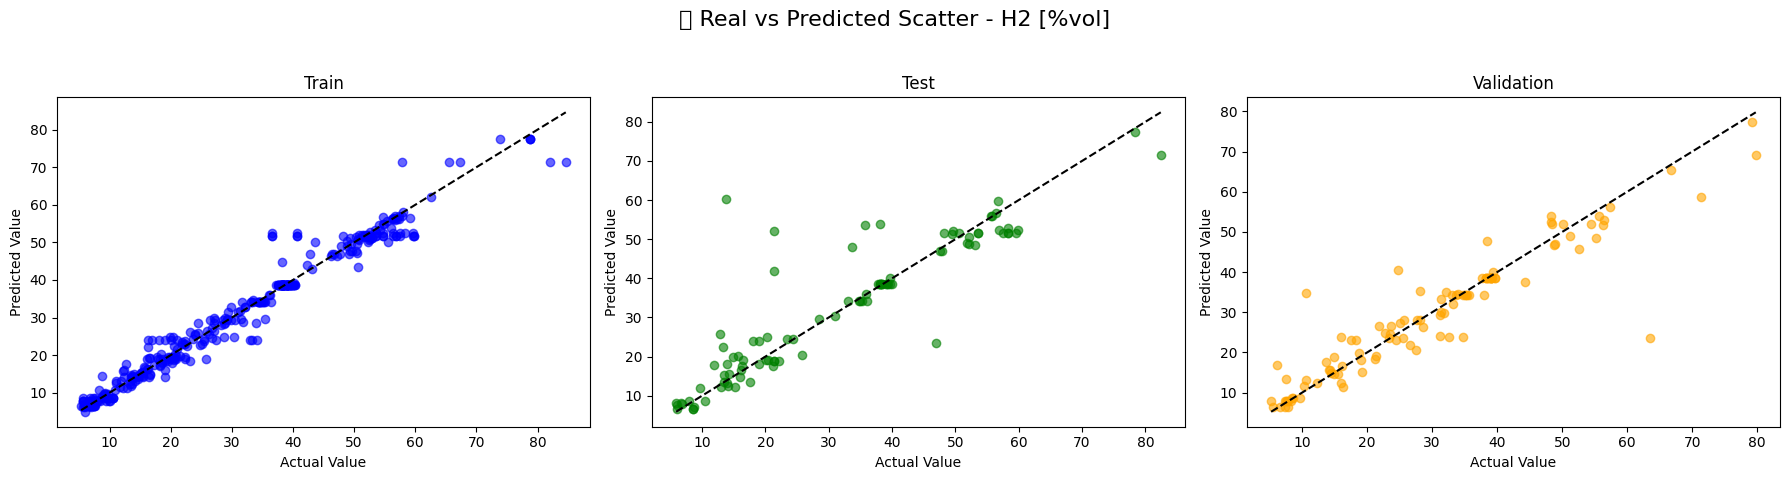

/tmp/ipython-input-15-486137625.py:135: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


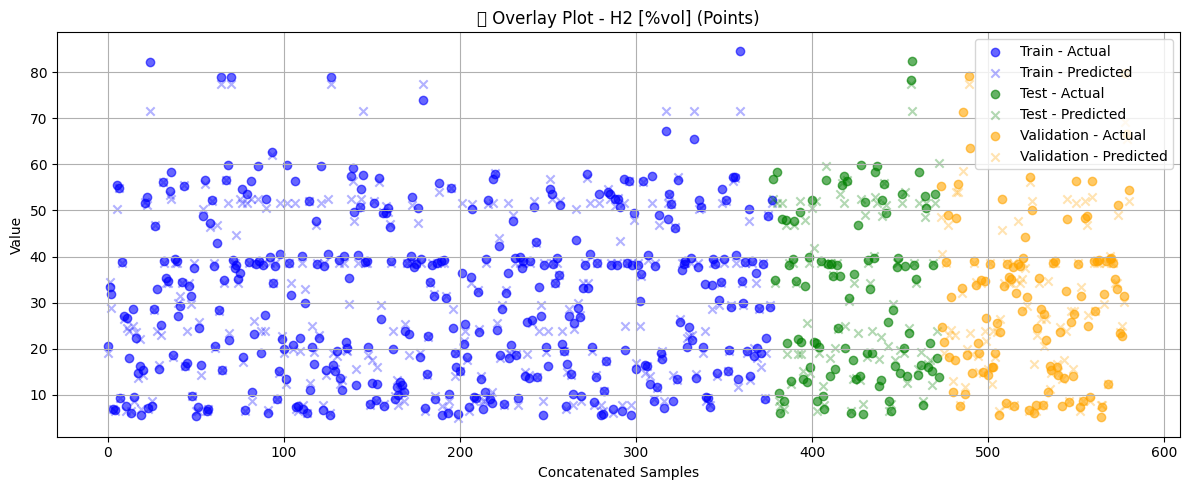

/tmp/ipython-input-15-486137625.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


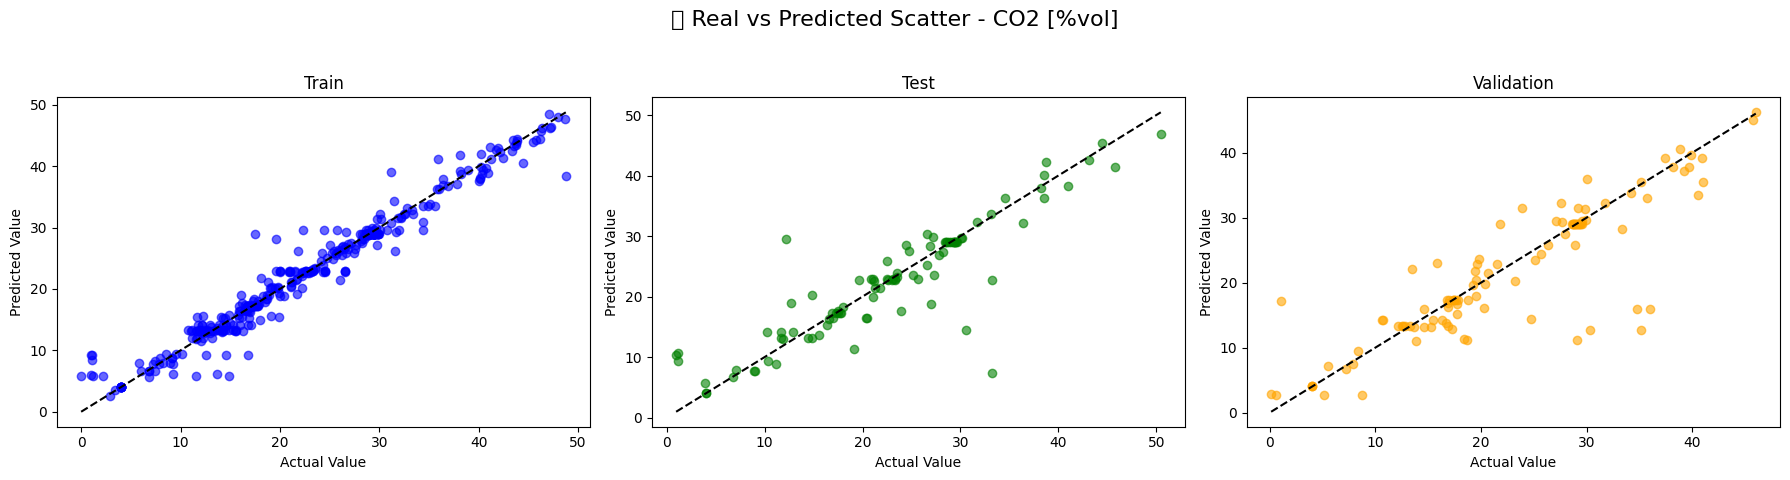

/tmp/ipython-input-15-486137625.py:135: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


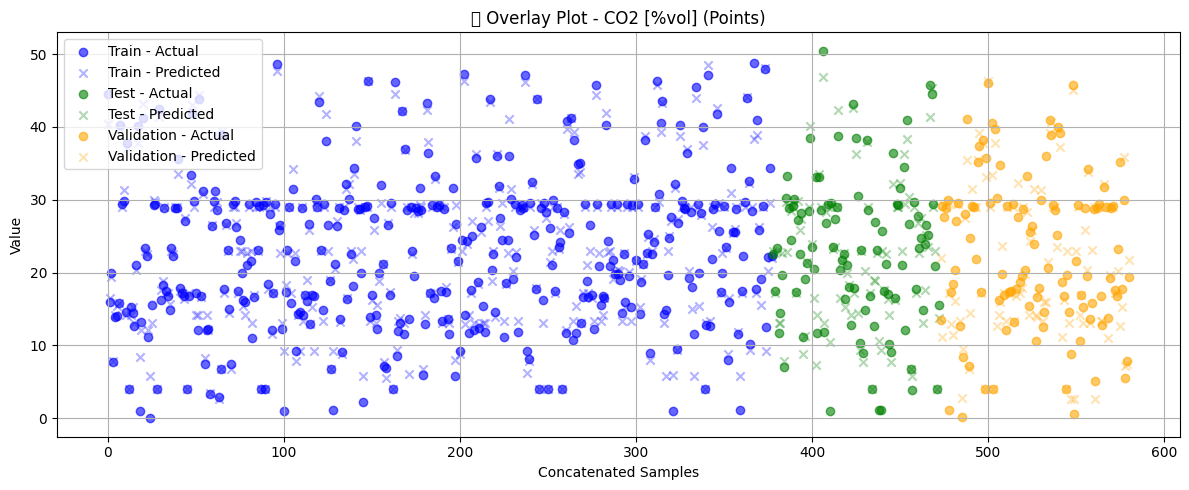

/tmp/ipython-input-15-486137625.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


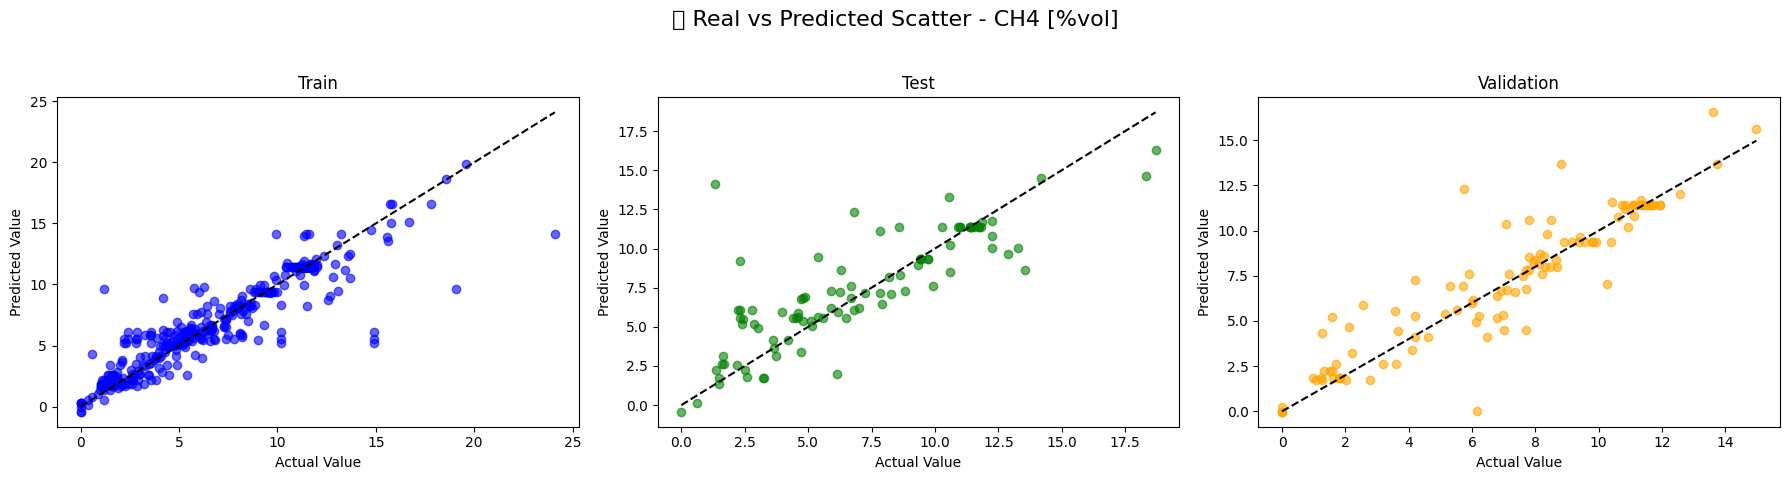

/tmp/ipython-input-15-486137625.py:135: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


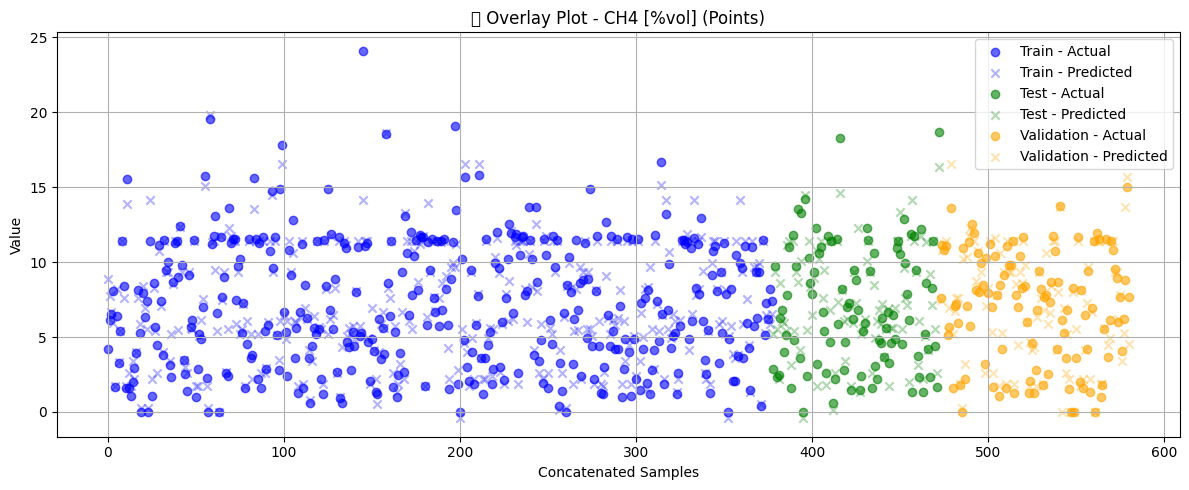

/tmp/ipython-input-15-486137625.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


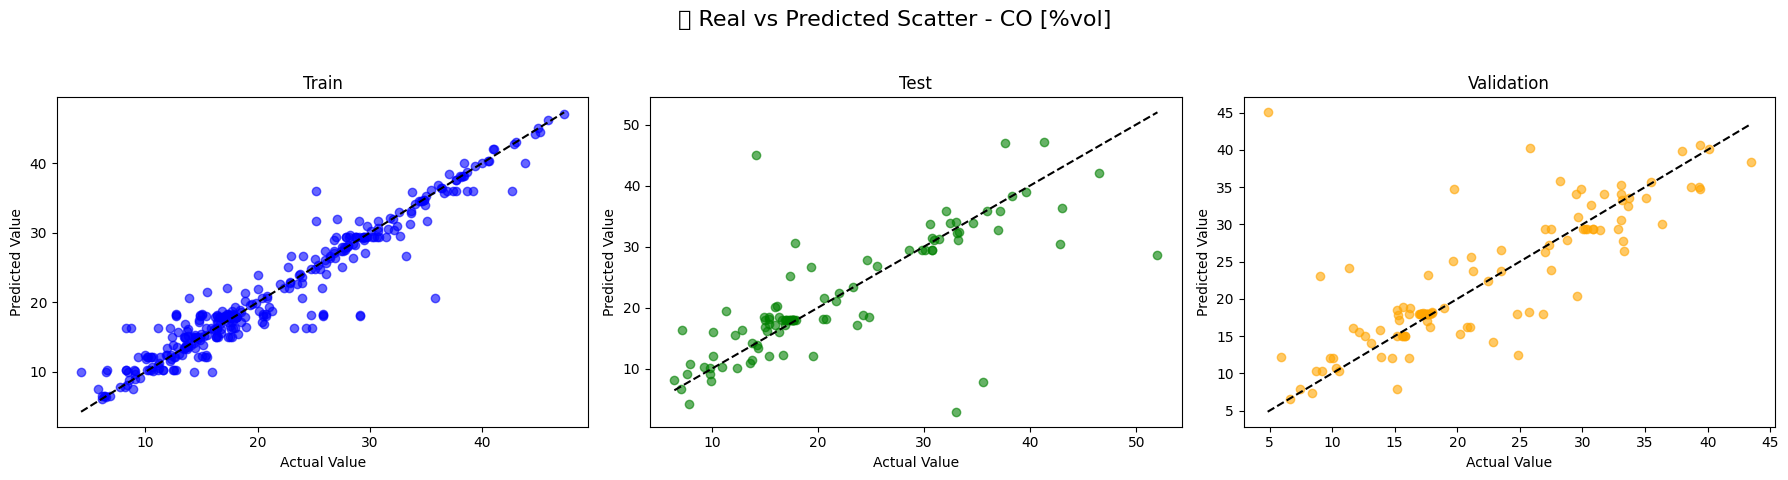

/tmp/ipython-input-15-486137625.py:135: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


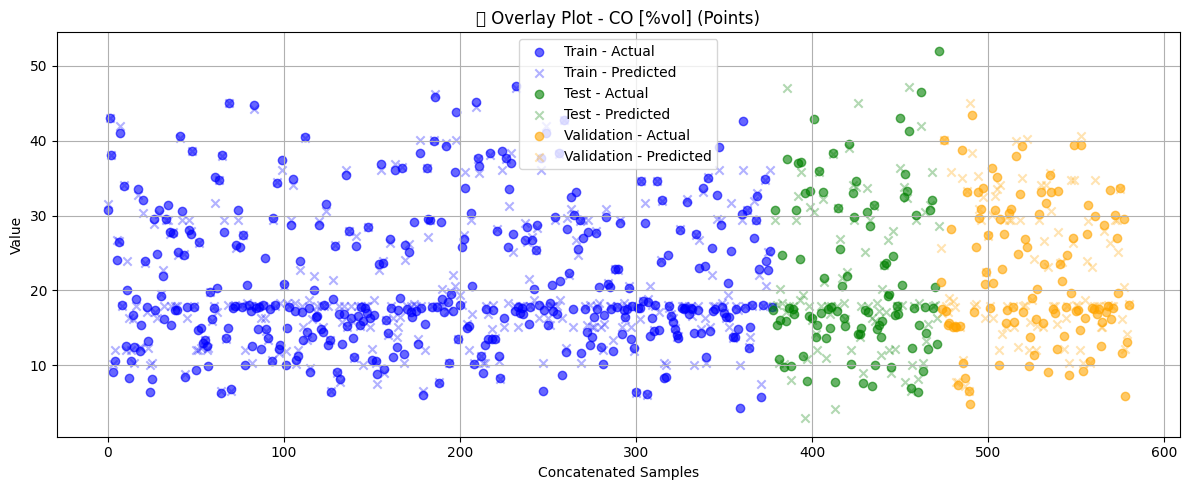

In [15]:
# Correct configurations per component
architectures = {
    'H2 [%vol]': (40, 40, 20),
    'CO2 [%vol]': (30, 30, 10),
    'CH4 [%vol]': (15, 5),
    'CO [%vol]': (40, 20, 10)
}

activations = {
    'H2 [%vol]': 'tanh',
    'CO2 [%vol]': 'tanh',
    'CH4 [%vol]': 'tanh',
    'CO [%vol]': 'tanh'
}

results = []

# Adjust X, y_train, y_test, y_val to your dataset
# Example:
# X_train, X_test, X_val, y_train, y_test, y_val

for comp in architectures.keys():
    # Normalization
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_tr_scaled = scaler_X.fit_transform(X_train)
    y_tr_scaled = scaler_y.fit_transform(y_train[[comp]])

    X_te_scaled = scaler_X.transform(X_test)
    X_val_scaled = scaler_X.transform(X_val)

    y_tr = y_train[comp].values.reshape(-1, 1)
    y_te = y_test[comp].values.reshape(-1, 1)
    y_val_ = y_val[comp].values.reshape(-1, 1)

    # Model
    model = MLPRegressor(
        solver='adam',
        activation=activations[comp],
        hidden_layer_sizes=architectures[comp],
        alpha=1e-5,
        learning_rate='constant',
        learning_rate_init=0.001,
        max_iter=5000,
        early_stopping=False,
        n_iter_no_change=300,
        batch_size='auto',
        random_state=42
    )

    model.fit(X_tr_scaled, y_tr_scaled.ravel())

    # Predictions (denormalized)
    y_pred_tr = scaler_y.inverse_transform(model.predict(X_tr_scaled).reshape(-1, 1))
    y_pred_te = scaler_y.inverse_transform(model.predict(X_te_scaled).reshape(-1, 1))
    y_pred_val = scaler_y.inverse_transform(model.predict(X_val_scaled).reshape(-1, 1))

    # Metrics
    n_tr, n_te, n_val = len(y_tr), len(y_te), len(y_val_)
    p = X_train.shape[1]

    def r2_adjusted(r2, n, p):
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    r2_adj_tr = r2_adjusted(r2_score(y_tr, y_pred_tr), n_tr, p)
    r2_adj_te = r2_adjusted(r2_score(y_te, y_pred_te), n_te, p)
    r2_adj_val = r2_adjusted(r2_score(y_val_, y_pred_val), n_val, p)

    results.append({
        'Component': comp,
        'Experiment': f'{comp}-Default',
        'Architecture': architectures[comp],
        'Activation': activations[comp],
        'Adjusted R² Train': r2_adj_tr,
        'Adjusted R² Test': r2_adj_te,
        'Adjusted R² Validation': r2_adj_val,
        'MAE Train': mean_absolute_error(y_tr, y_pred_tr),
        'MAE Test': mean_absolute_error(y_te, y_pred_te),
        'MAE Validation': mean_absolute_error(y_val_, y_pred_val),
        'SSE Train': np.sum((y_tr - y_pred_tr) ** 2),
        'SSE Test': np.sum((y_te - y_pred_te) ** 2),
        'SSE Validation': np.sum((y_val_ - y_pred_val) ** 2)
    })

    # Scatter plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"📈 Real vs Predicted Scatter - {comp}", fontsize=16)

    axs[0].scatter(y_tr, y_pred_tr, color='blue', alpha=0.6)
    axs[0].plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'k--')
    axs[0].set_title('Train')
    axs[0].set_xlabel('Actual Value')
    axs[0].set_ylabel('Predicted Value')

    axs[1].scatter(y_te, y_pred_te, color='green', alpha=0.6)
    axs[1].plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'k--')
    axs[1].set_title('Test')
    axs[1].set_xlabel('Actual Value')
    axs[1].set_ylabel('Predicted Value')

    axs[2].scatter(y_val_, y_pred_val, color='orange', alpha=0.6)
    axs[2].plot([y_val_.min(), y_val_.max()], [y_val_.min(), y_val_.max()], 'k--')
    axs[2].set_title('Validation')
    axs[2].set_xlabel('Actual Value')
    axs[2].set_ylabel('Predicted Value')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Overlay plot with points (scatter)
    plt.figure(figsize=(12, 5))

    # Indices of each segment (simulated concatenation)
    idx_te = np.arange(len(y_tr), len(y_tr) + len(y_te))
    idx_val = np.arange(len(y_tr) + len(y_te), len(y_tr) + len(y_te) + len(y_val_))

    # Train
    plt.scatter(range(len(y_tr)), y_tr, label='Train - Actual', color='blue', alpha=0.6, marker='o')
    plt.scatter(range(len(y_tr)), y_pred_tr, label='Train - Predicted', color='blue', alpha=0.3, marker='x')

    # Test
    plt.scatter(idx_te, y_te, label='Test - Actual', color='green', alpha=0.6, marker='o')
    plt.scatter(idx_te, y_pred_te, label='Test - Predicted', color='green', alpha=0.3, marker='x')

    # Validation
    plt.scatter(idx_val, y_val_, label='Validation - Actual', color='orange', alpha=0.6, marker='o')
    plt.scatter(idx_val, y_pred_val, label='Validation - Predicted', color='orange', alpha=0.3, marker='x')

    plt.title(f'📉 Overlay Plot - {comp} (Points)')
    plt.xlabel('Concatenated Samples')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


H₂ [%vol]

The H₂ component exhibited the best performance among the evaluated models, according to the quantitative metrics. In the training set, most data points are well aligned with the identity line, indicating the model’s strong learning capability. However, the test set shows greater dispersion, with deviations distributed both above and below the line. Interestingly, the validation set outperformed the test set, with lower dispersion and a higher concentration of points around the ideal line. The overlay plot does not reveal any specific region of the domain with systematic prediction errors. Error patterns are consistent across all three subsets (training, test, and validation).

CO₂ [%vol]

CO₂ was the second-best performing component in terms of quantitative metrics. Similar to H₂, the model fit the training data well, with predicted points close to the reference line. In the test set, an increase in error dispersion is observed, indicating limited generalization capacity. In contrast, the validation set shows improved behavior, with lower variability and greater adherence to the identity line—even surpassing the test performance. The overlay plots do not indicate any localized prediction deficiencies; the error pattern appears uniform, with no identifiable input regions exhibiting significant prediction failures.

CH₄ [%vol]

The CH₄ model showed the second-worst overall performance. A noteworthy aspect in this case is the difference in data range across the subsets (as observed in the exploratory statistical analysis). The model was primarily trained on values ranging from 0 to 15, which aligns well with the validation set, which shares this range. However, the test set contains significantly higher values, for which the model was not adequately exposed during training. This may explain the poorer test performance relative to validation. Nonetheless, the overlay plots do not clearly reveal specific regions with predictive failures; the error patterns appear relatively consistent across subsets.

CO [%vol]

The CO component yielded the worst results among the models analyzed. In addition to the variation in range between data subsets (also confirmed statistically), the test and validation sets show predictions with substantial errors, often far from the reference line for both low and high values. The overlay plot highlights that the largest errors occur in the higher value regions of the component, suggesting the model struggles to extrapolate to the extremes of the domain.

These findings underscore the need to reassess the representativeness of the training dataset and to consider applying regularization and balancing techniques to improve the model's generalization capability. In this context, a new experimental phase will be conducted using a training dataset balanced through the SMOGN technique (Synthetic Minority Over-sampling Technique for Regression with Gaussian Noise), in order to investigate potential improvements in predictive performance

# ANN Performance with SMOGN Application

/tmp/ipython-input-16-3819281169.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


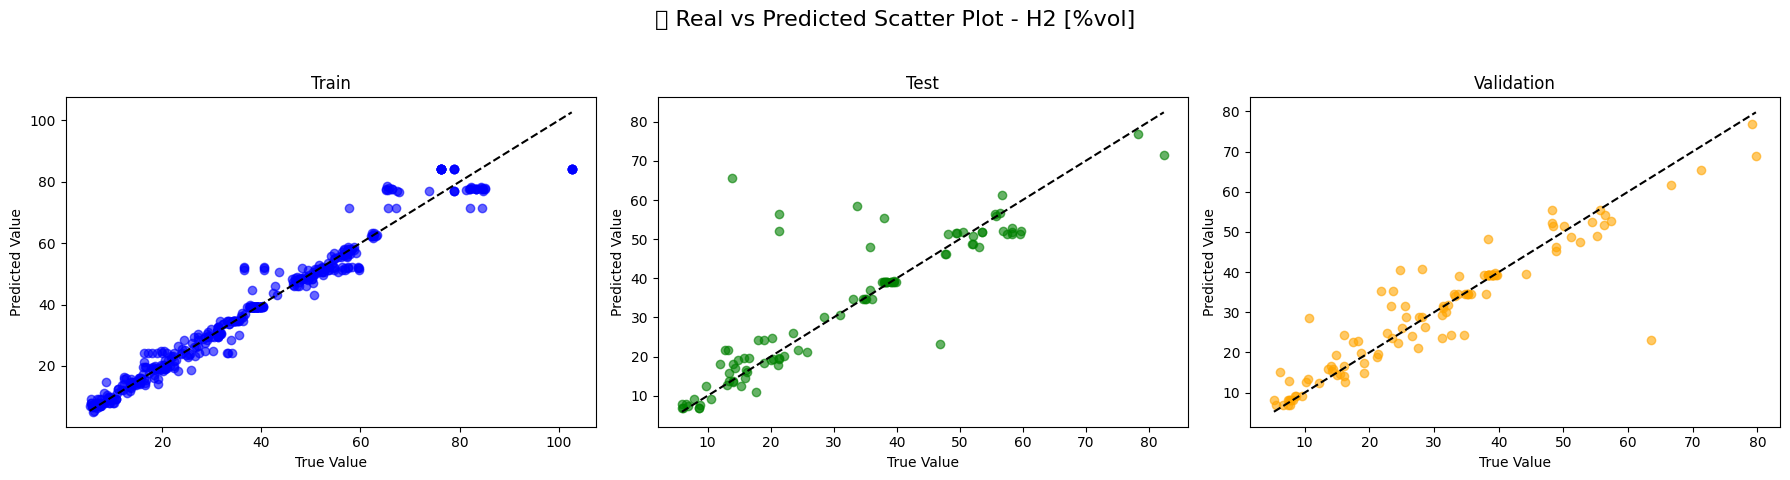

/tmp/ipython-input-16-3819281169.py:135: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


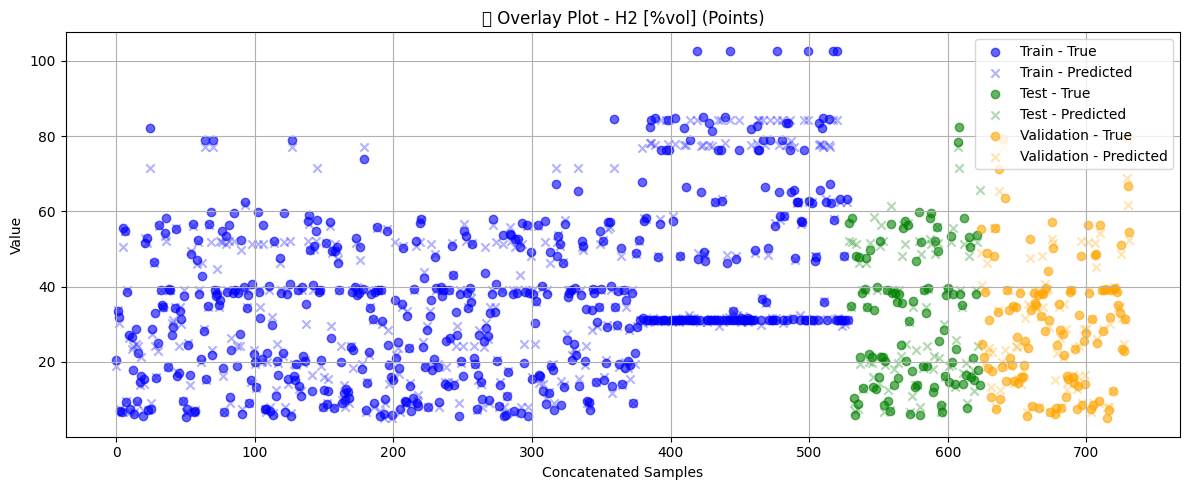

/tmp/ipython-input-16-3819281169.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


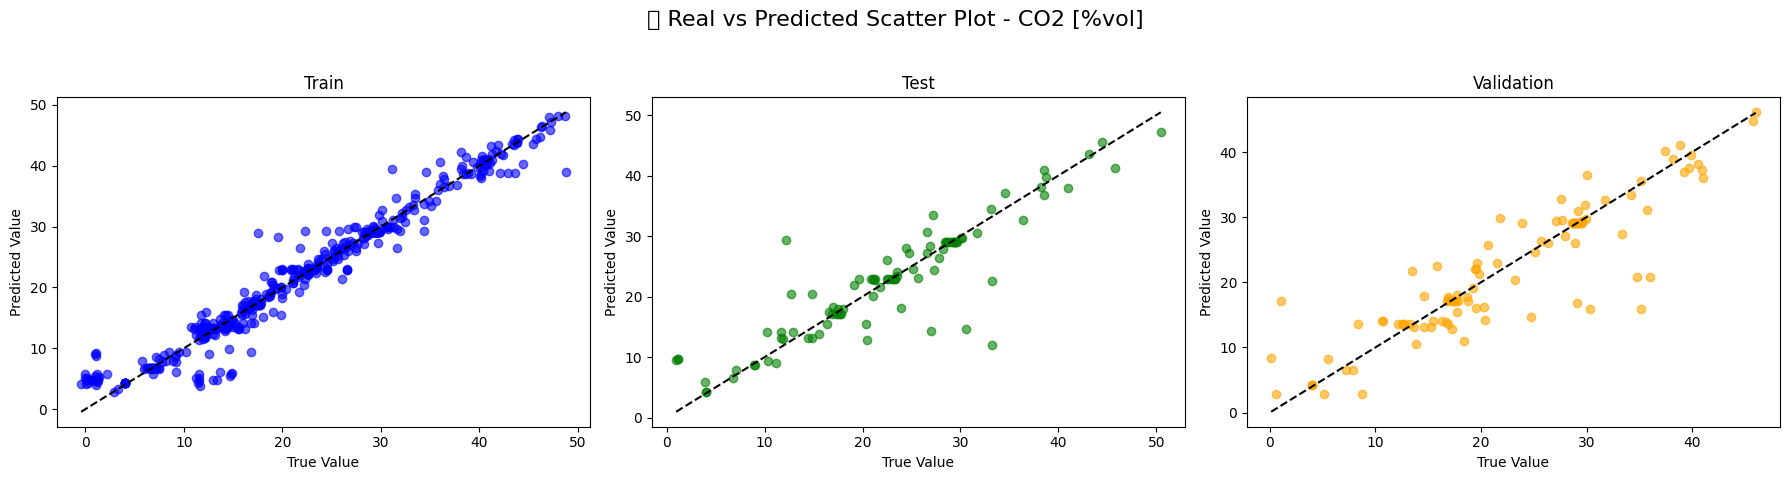

/tmp/ipython-input-16-3819281169.py:135: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


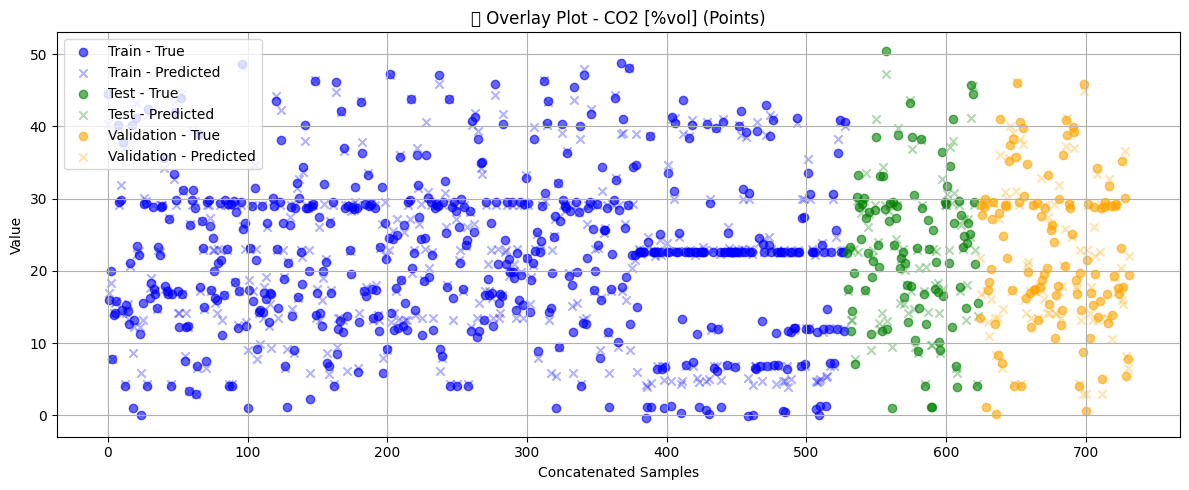

/tmp/ipython-input-16-3819281169.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


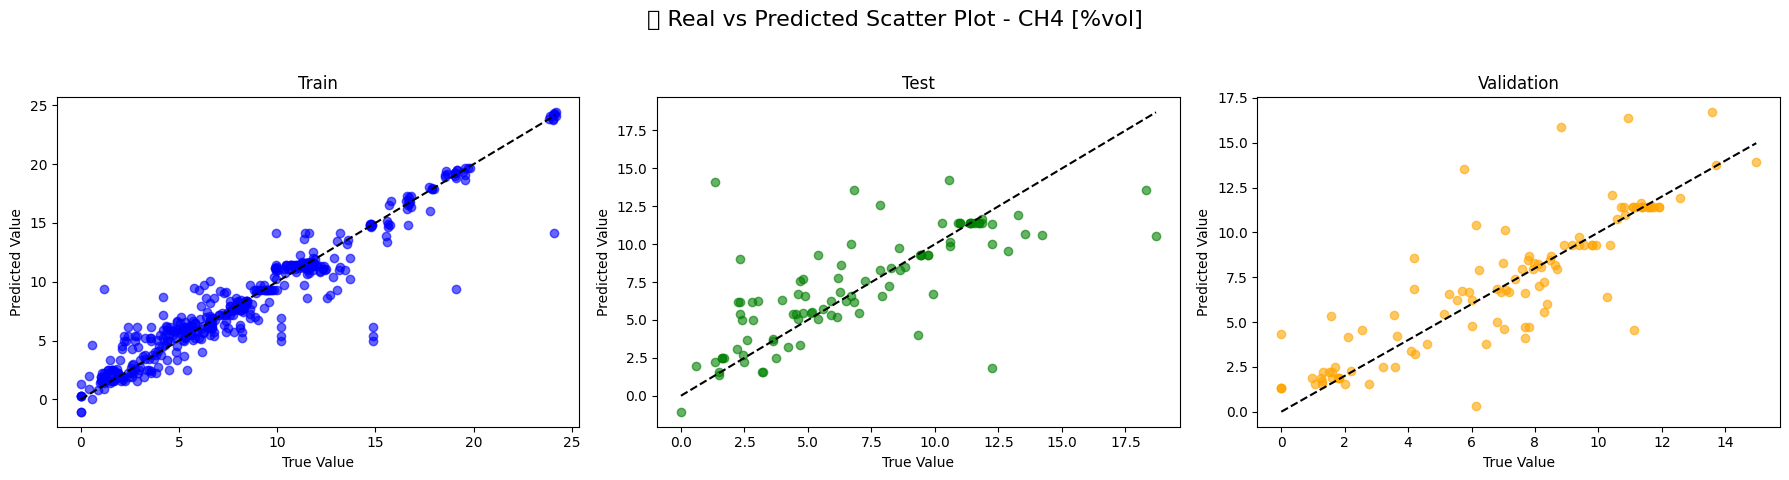

/tmp/ipython-input-16-3819281169.py:135: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


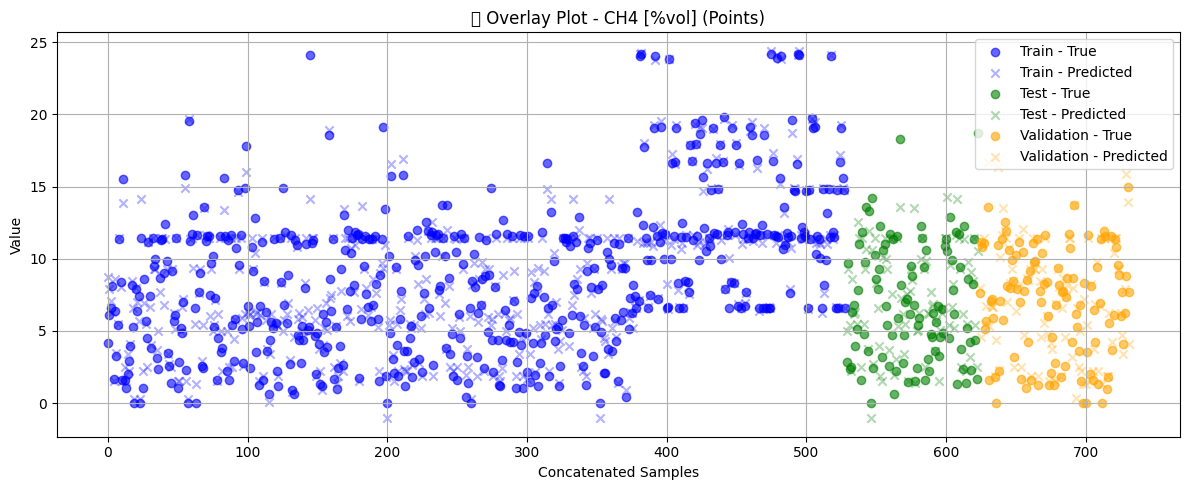

/tmp/ipython-input-16-3819281169.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


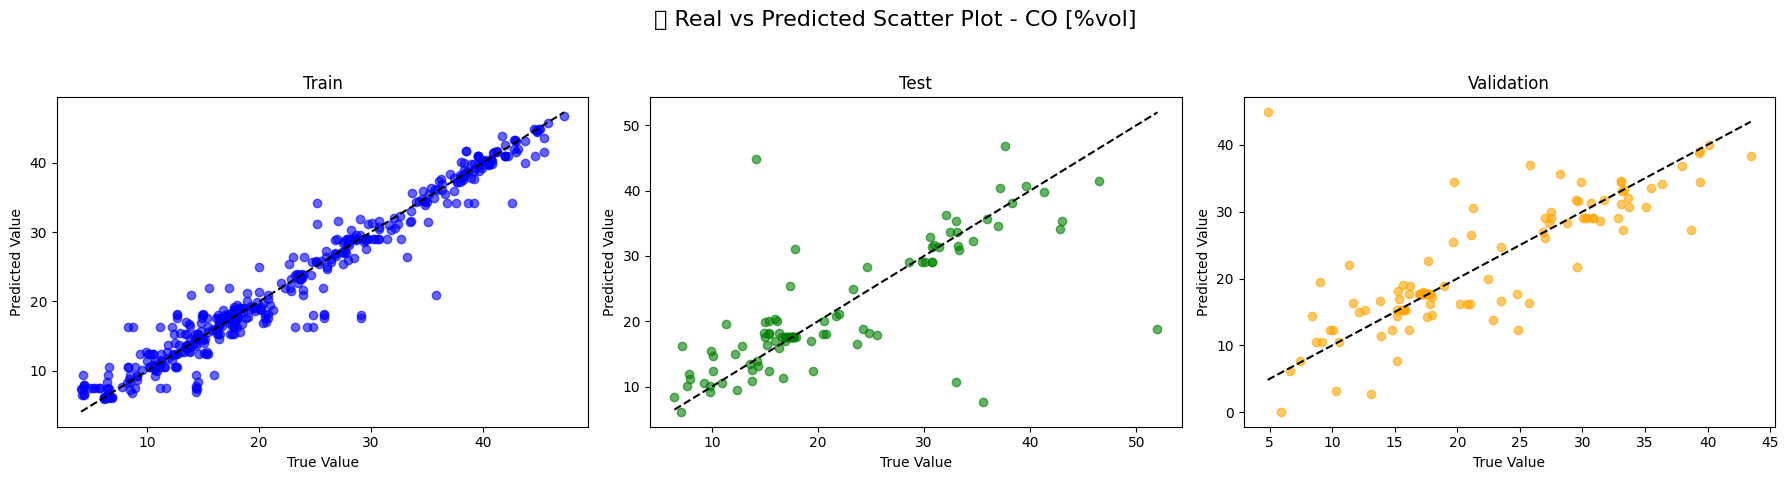

/tmp/ipython-input-16-3819281169.py:135: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


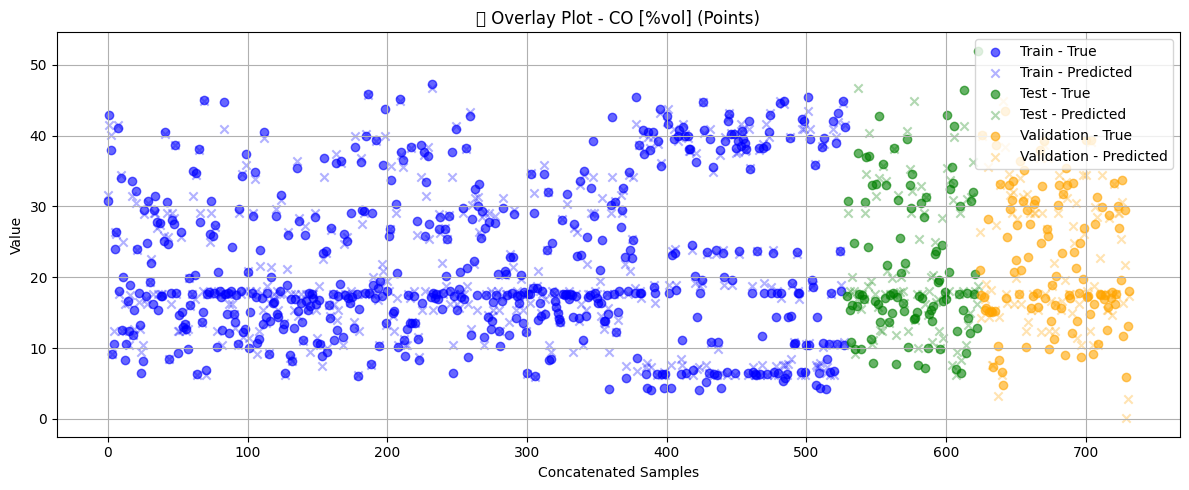

### 📊 SMOGN Results for **CH4 [%vol]**

| Experiment              | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CH4 [%vol]-(15, 5)-tanh | (15, 5)        | tanh         |            0.912473 |           0.470958 |                 0.677007 |    0.839055 |    1.70454 |          1.25522 |     1216.31 |    734.988 |          441.084 |

### 📊 SMOGN Results for **CO [%vol]**

| Experiment                  | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:----------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CO [%vol]-(40, 20, 10)-tanh | (40, 20, 10)   | tanh         |            0.955958 |            0.48886 |                 0.541855 |     1.34948 |    3.72528 |          3.38005 |     2780.57 |    4596.88 |          3722.41 |

### 📊 SMOGN Results for **CO2 [%vol]**

| Experiment                   | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:-----------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| CO2 [%vol]-(30, 30, 10)-tanh | (30, 30, 10)   | tanh         |             0.95839 |           0.783403 |                 0.776977 |     1.28418 |    2.53806 |           2.8517 |     2644.31 |    1963.67 |          2384.32 |

### 📊 SMOGN Results for **H2 [%vol]**

| Experiment                  | Architecture   | Activation   |   Adjusted R² Train |   Adjusted R² Test |   Adjusted R² Validation |   MAE Train |   MAE Test |   MAE Validation |   SSE Train |   SSE Test |   SSE Validation |
|:----------------------------|:---------------|:-------------|--------------------:|-------------------:|-------------------------:|------------:|-----------:|-----------------:|------------:|-----------:|-----------------:|
| H2 [%vol]-(40, 40, 20)-tanh | (40, 40, 20)   | tanh         |             0.96452 |           0.730151 |                 0.855857 |     2.21135 |    4.36757 |          3.39718 |     8314.93 |    7533.55 |          4020.79 |

In [16]:
# Configurations per component
arquiteturas = {
    'H2 [%vol]': (40, 40, 20),
    'CO2 [%vol]': (30, 30, 10),
    'CH4 [%vol]': (15, 5),
    'CO [%vol]': (40, 20, 10)
}

ativacoes = {
    'H2 [%vol]': 'tanh',
    'CO2 [%vol]': 'tanh',
    'CH4 [%vol]': 'tanh',
    'CO [%vol]': 'tanh'
}

novos_resultados = []

for comp in arquiteturas.keys():
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_tr_scaled = scaler_X.fit_transform(X_train_balanced)
    y_tr_scaled = scaler_y.fit_transform(y_train_balanced[[comp]])

    X_te_scaled = scaler_X.transform(X_test)
    X_val_scaled = scaler_X.transform(X_val)

    y_tr = y_train_balanced[comp].values.reshape(-1, 1)
    y_te = y_test[comp].values.reshape(-1, 1)
    y_val_ = y_val[comp].values.reshape(-1, 1)

    model = MLPRegressor(
        solver='adam',
        activation=ativacoes[comp],
        hidden_layer_sizes=arquiteturas[comp],
        alpha=1e-5,
        learning_rate='constant',
        learning_rate_init=0.001,
        max_iter=5000,
        early_stopping=False,
        n_iter_no_change=300,
        batch_size='auto',
        random_state=42
    )

    model.fit(X_tr_scaled, y_tr_scaled.ravel())

    y_pred_tr = scaler_y.inverse_transform(model.predict(X_tr_scaled).reshape(-1, 1))
    y_pred_te = scaler_y.inverse_transform(model.predict(X_te_scaled).reshape(-1, 1))
    y_pred_val = scaler_y.inverse_transform(model.predict(X_val_scaled).reshape(-1, 1))

    n_tr, n_te, n_val = len(y_tr), len(y_te), len(y_val_)
    p = X_train_balanced.shape[1]

    def r2_adjusted(r2, n, p):
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    r2_tr = r2_score(y_tr, y_pred_tr)
    r2_te = r2_score(y_te, y_pred_te)
    r2_val = r2_score(y_val_, y_pred_val)

    r2_adj_tr = r2_adjusted(r2_tr, n_tr, p)
    r2_adj_te = r2_adjusted(r2_te, n_te, p)
    r2_adj_val = r2_adjusted(r2_val, n_val, p)

    mae_tr = mean_absolute_error(y_tr, y_pred_tr)
    mae_te = mean_absolute_error(y_te, y_pred_te)
    mae_val = mean_absolute_error(y_val_, y_pred_val)

    sse_tr = np.sum((y_tr - y_pred_tr) ** 2)
    sse_te = np.sum((y_te - y_pred_te) ** 2)
    sse_val = np.sum((y_val_ - y_pred_val) ** 2)

    novos_resultados.append({
        'Component': comp,
        'Experiment': f'{comp}-{arquiteturas[comp]}-{ativacoes[comp]}',
        'Architecture': arquiteturas[comp],
        'Activation': ativacoes[comp],
        'Adjusted R² Train': r2_adj_tr,
        'Adjusted R² Test': r2_adj_te,
        'Adjusted R² Validation': r2_adj_val,
        'MAE Train': mae_tr,
        'MAE Test': mae_te,
        'MAE Validation': mae_val,
        'SSE Train': sse_tr,
        'SSE Test': sse_te,
        'SSE Validation': sse_val
    })

    # ==== Scatter plot ====
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"📈 Real vs Predicted Scatter Plot - {comp}", fontsize=16)

    axs[0].scatter(y_tr, y_pred_tr, color='blue', alpha=0.6)
    axs[0].plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'k--')
    axs[0].set_title('Train')
    axs[0].set_xlabel('True Value')
    axs[0].set_ylabel('Predicted Value')

    axs[1].scatter(y_te, y_pred_te, color='green', alpha=0.6)
    axs[1].plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'k--')
    axs[1].set_title('Test')
    axs[1].set_xlabel('True Value')
    axs[1].set_ylabel('Predicted Value')

    axs[2].scatter(y_val_, y_pred_val, color='orange', alpha=0.6)
    axs[2].plot([y_val_.min(), y_val_.max()], [y_val_.min(), y_val_.max()], 'k--')
    axs[2].set_title('Validation')
    axs[2].set_xlabel('True Value')
    axs[2].set_ylabel('Predicted Value')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ==== Overlay plot with points ====
    plt.figure(figsize=(12, 5))

    idx_te = np.arange(len(y_tr), len(y_tr) + len(y_te))
    idx_val = np.arange(len(y_tr) + len(y_te), len(y_tr) + len(y_te) + len(y_val_))

    plt.scatter(range(len(y_tr)), y_tr, label='Train - True', color='blue', alpha=0.6, marker='o')
    plt.scatter(range(len(y_tr)), y_pred_tr, label='Train - Predicted', color='blue', alpha=0.3, marker='x')

    plt.scatter(idx_te, y_te, label='Test - True', color='green', alpha=0.6, marker='o')
    plt.scatter(idx_te, y_pred_te, label='Test - Predicted', color='green', alpha=0.3, marker='x')

    plt.scatter(idx_val, y_val_, label='Validation - True', color='orange', alpha=0.6, marker='o')
    plt.scatter(idx_val, y_pred_val, label='Validation - Predicted', color='orange', alpha=0.3, marker='x')

    plt.title(f'📉 Overlay Plot - {comp} (Points)')
    plt.xlabel('Concatenated Samples')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ==== Display metrics ====
df_novos_resultados = pd.DataFrame(novos_resultados)
df_novos_resultados = df_novos_resultados.sort_values(by=['Component', 'Adjusted R² Validation'], ascending=[True, False])

for comp in df_novos_resultados['Component'].unique():
    df_comp = df_novos_resultados[df_novos_resultados['Component'] == comp].copy()
    df_comp = df_comp.sort_values(by='Adjusted R² Validation', ascending=False)

    md_table = df_comp[[
        'Experiment', 'Architecture', 'Activation',
        'Adjusted R² Train', 'Adjusted R² Test', 'Adjusted R² Validation',
        'MAE Train', 'MAE Test', 'MAE Validation',
        'SSE Train', 'SSE Test', 'SSE Validation'
    ]].to_markdown(index=False)

    display(Markdown(f"### 📊 SMOGN Results for **{comp}**\n\n{md_table}"))


Interestingly, in none of the tested architectures did the inclusion of synthetic data lead to improved performance; on the contrary, a degradation in results was observed. Visual analysis through overlay plots revealed a notable behavior: the synthetic data tend to concentrate within a narrow range, forming almost a line along the distribution. This indicates that the generated data are predominantly clustered in a specific region of the sample space.

Instead of contributing to better model generalization, the synthetic data ended up reinforcing already existing patterns. It is worth noting that, when analyzing the histograms of the component distributions with the augmented data, an increase in both the range and the number of samples was indeed observed. However, these same histograms also highlighted a reinforcement of the predominant trends present in the original distributions, which may explain the negative effect on the predictive capability of the models.

